In [5]:
!pip install perceval-quandela merlinquantum


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\Asus\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import torch, torch.nn as nn
import merlin as ML
import shutil
import json
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import RandomSampler, DataLoader
from tqdm import tqdm
import perceval as pcvl
import sys; sys.path.insert(0, '..')
import pandas as pd
from models.qgan import QGAN
from helpers.digits import DigitsDataset
#from torch.utils.data import Dataset
from pathlib import Path
import re
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from helpers.pqc import ParametrizedQuantumCircuit
import math

In [126]:
EPS = 1e-6

class MerlinPatchGenerator(nn.Module):
    def __init__(
        self,
        image_size,
        gen_count,
        gen_arch,
        input_state,
        noise_dim,
        pnr,
        lossy,
        shots=3000,
        use_clements=False,
    ):
        super().__init__()
        self.image_size  = int(image_size)
        self.gen_count   = int(gen_count)
        self.noise_dim   = int(noise_dim)
        assert (self.image_size * self.image_size) % self.gen_count == 0, \
            "image_size^2 must be divisible by gen_count"
        self.pixels_per_patch = (self.image_size * self.image_size) // self.gen_count

        # Perceval state
        self.input_state = pcvl.BasicState(input_state) if not hasattr(input_state, "m") else input_state

        # circuit template from pqc.py architecture
        n_modes  = self.input_state.m if hasattr(self.input_state, "m") else len(self.input_state)
        template = ParametrizedQuantumCircuit(n_modes, gen_arch, use_clements).circuit

        # number of enc[...] params must equal noise_dim (per patch)
        enc_params = [p for p in template.get_parameters() if "enc" in getattr(p, "name", "")]
        if len(enc_params) != self.noise_dim:
            raise ValueError(
                f"noise_dim ({self.noise_dim}) must equal number of enc[...] params in circuit ({len(enc_params)})."
            )

        # Merlin sampling
        layer_shots = 0 if not lossy else shots

        class _ClampQL(nn.Module):
            #Clamp QuantumLayer inputs to (EPS, 1-EPS)
            def __init__(self, ql):
                super().__init__()
                self.ql = ql
            def forward(self, x):
                x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=0.0)
                x = torch.clamp(x, EPS, 1.0 - EPS)
                return self.ql(x)

        class _TrainableQL(nn.Module):
            
            #Trainable wrapper that *pushes the actual tensor* of angles into the quantum layer.
            #Falls back to float mapping if the backend doesn't accept tensors (prints once).
            
            def __init__(self, circuit_template, input_state, noise_dim, shots, no_bunching):
                super().__init__()
                self.circuit = circuit_template.copy()
                self.ql = ML.QuantumLayer(
                    input_size=noise_dim,
                    circuit=self.circuit,
                    input_state=input_state,
                    trainable_parameters=["phi", "psi", "theta"],
                    input_parameters=["enc"],
                    output_mapping_strategy=ML.OutputMappingStrategy.NONE,
                    shots=shots,
                    no_bunching=no_bunching,
                )

                # Collect trainable parameter names and initial values
                names, vals = [], []
                for p in self.circuit.get_parameters():
                    pname = getattr(p, "name", "")
                    if any(k in pname for k in ("phi", "psi", "theta")):
                        names.append(pname)
                        try:
                            vals.append(float(getattr(p, "value", 0.0)))
                        except Exception:
                            vals.append(0.0)
                if len(names) == 0:
                    names = ["theta_dummy"]
                    vals  = [0.0]

                self.param_names = names
                self.theta = nn.Parameter(torch.tensor(vals, dtype=torch.float32))

                self.clamped_ql = _ClampQL(self.ql)
                self._warned_detach = False

            def _apply_params_tensor_first(self, theta_tensor: torch.Tensor):
                
                if hasattr(self.ql, "set_params_tensor"):
                    self.ql.set_params_tensor(theta_tensor, names=self.param_names)
                    return True
                if hasattr(self.ql, "set_parameter_tensors"):
                    self.ql.set_parameter_tensors({n: t for n, t in zip(self.param_names, theta_tensor)})
                    return True
                # Dict of tensors (some versions accept torch tensors in set_parameter_values)
                try:
                    self.ql.set_parameter_values({n: t for n, t in zip(self.param_names, theta_tensor)})
                    return True
                except Exception:
                    pass
                try:
                    self.circuit.set_parameters({n: t for n, t in zip(self.param_names, theta_tensor)})
                    return True
                except Exception:
                    pass
                if hasattr(self.ql, "ansatz"):
                    try:
                        self.ql.ansatz.set_parameters({n: t for n, t in zip(self.param_names, theta_tensor)})
                        return True
                    except Exception:
                        pass
                return False

            def _push(self):



                """
                Push the trainable vector into the quantum layer.
                Tries tensor path first; if unsupported, falls back to floats (no grad through circuit).
                """


                theta = self.theta  # keep as tensor (no detach, no no_grad)
                ok = self._apply_params_tensor_first(theta)
                if ok:
                    return
                # Fallback: convert to float (non-differentiable through circuit params)
                mapping_float = {n: float(v.item()) for n, v in zip(self.param_names, theta)}
                pushed = False
                for fn in ("set_parameter_values",):
                    if hasattr(self.ql, fn):
                        try:
                            getattr(self.ql, fn)(mapping_float)
                            pushed = True
                            break
                        except Exception:
                            pass
                if not pushed:
                    try:
                        self.circuit.set_parameters(mapping_float)
                        pushed = True
                    except Exception:
                        pass
                if not pushed and hasattr(self.ql, "ansatz"):
                    try:
                        self.ql.ansatz.set_parameters(mapping_float)
                        pushed = True
                    except Exception:
                        pass
                if pushed and not self._warned_detach:
                    print("[Note] QuantumLayer did not accept tensors; fell back to float mapping. "
                          "Autograd will NOT flow through circuit parameters.")
                    self._warned_detach = True

            def forward(self, x):
                self._push()
                return self.clamped_ql(x)

        self.layers = nn.ModuleList([
            _TrainableQL(
                circuit_template=template,
                input_state=self.input_state,
                noise_dim=self.noise_dim,
                shots=layer_shots,
                no_bunching=(not pnr),
            )
            for _ in range(self.gen_count)
        ])

        # One head per patch; LazyLinear autosizes to [q_out || latent]
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.LazyLinear(2 * self.pixels_per_patch),
                nn.GELU(),
                nn.Linear(2 * self.pixels_per_patch, self.pixels_per_patch),
            )
            for _ in range(self.gen_count)
        ])

    def forward(self, z):
        # sanitize & map latent into (0,1) strictly
        if not torch.is_tensor(z):
            z = torch.as_tensor(z)
        z = torch.nan_to_num(z, nan=0.0, posinf=6.0, neginf=-6.0)
        z01 = torch.sigmoid(z)                 # (0,1)
        z01 = z01.mul_(1 - 2*EPS).add_(EPS)    # (EPS, 1-EPS)

        B, L = z01.shape
        expected = self.noise_dim * self.gen_count
        if L != expected:
            raise ValueError(
                f"latent dim {L} != noise_dim*gen_count ({expected}). "
                f"Sample z with shape (B, {expected})."
            )

        # exact split into gen_count parts of size noise_dim
        parts = z01.view(B, self.gen_count, self.noise_dim).unbind(dim=1)  # list[(B, noise_dim)]

        patches = []
        for layer, head, zi in zip(self.layers, self.heads, parts):
            zi = torch.clamp(torch.nan_to_num(zi, nan=0.0, posinf=1.0, neginf=0.0), EPS, 1.0 - EPS)
            q_out = layer(zi)                        # (B, q_dim)
            h     = torch.cat([q_out, zi], dim=1)    # latent skip
            patches.append(head(h))                  # (B, pixels_per_patch)

        img_flat = torch.cat(patches, dim=1)        # (B, H*W)
        x = torch.sigmoid(img_flat)                  # soft squash (0,1)

        # Per-image min–max normalization (robust, avoids black/flat)
        x_min = x.amin(dim=1, keepdim=True)
        x_max = x.amax(dim=1, keepdim=True)
        span  = (x_max - x_min)

        x_norm = (x - x_min) / span.clamp_min(EPS)

        tol = 1e-3
        is_flat = (span < tol)
        if is_flat.any():
            x_center = x - x.mean(dim=1, keepdim=True)
            std = x_center.std(dim=1, keepdim=True).clamp_min(EPS)
            x_boost = (x_center / std) * 0.15 + 0.5
            x_boost = x_boost.clamp(0.0, 1.0)
            out = torch.where(is_flat, x_boost, x_norm)
        else:
            out = x_norm
            out = out.clamp(0.0, 1.0)
            out = 2.0*out - 1.0  # to (-1, 1)

        return out

    def generate(self, noise):
        with torch.no_grad():
            return self.forward(noise)

In [127]:
class MerlinDiscriminator(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(64, 64), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.1),
            nn.Linear(64, 32), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.1),
            nn.Linear(32, 1) 
        )

    def forward(self, x):
        if x.dim() == 4:  # (B,1,8,8)
            x = x.view(x.size(0), -1)
        return self.net(x).view(-1)  # logits

In [128]:
class QGAN:
    def __init__(self, image_size, gen_count, gen_arch, input_state, noise_dim, batch_size, pnr, lossy):
        self.image_size = image_size
        self.gen_count = gen_count
        self.noise_dim = max(1, int(noise_dim))
        self.latent_dim = self.noise_dim * max(1, int(gen_count))
        self.batch_size = int(batch_size)

        # Generator & Discriminator
        self.G = MerlinPatchGenerator(
            image_size=image_size,
            gen_count=gen_count,
            gen_arch=gen_arch,
            input_state=pcvl.BasicState(input_state) if not hasattr(input_state, "m") else input_state,
            noise_dim=noise_dim,
            pnr=pnr,
            lossy=lossy,
            shots=3000,
            use_clements=False,
        )
        self.D = MerlinDiscriminator(image_size=image_size)  # logits

        # Opts (set during fit)
        self.optG = None
        self.optD = None

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.G.to(self.device)
        self.D.to(self.device)

        # Warm-up once to initialize any Lazy* params BEFORE counting
        with torch.no_grad():
            _ = self.G(torch.zeros(1, self.latent_dim, device=self.device))
            _ = self.D(torch.zeros(1, self.image_size * self.image_size, device=self.device))

        # Safe parameter count
        def _count_params(m):
            total = 0
            for p in m.parameters():
                if not getattr(p, "requires_grad", False):
                    continue
                try:
                    total += p.numel()
                except Exception:
                    continue
            return total

        print(f"Generator trainable params: {_count_params(self.G)}")
        print(f"Discriminator trainable params: {_count_params(self.D)}")

    # always return a non-empty trainable vector for logging
    def _get_trainable_vector(self):
        vecs = []
        if hasattr(self.G, "layers"):
            for layer in self.G.layers:
                t = getattr(layer, "theta", None)
                if isinstance(t, torch.Tensor):
                    vecs.append(t.view(-1))
        if vecs:
            return torch.cat(vecs)

        params = [p.view(-1) for p in self.G.parameters() if isinstance(p, torch.Tensor) and p.requires_grad]
        if params:
            return torch.cat(params)

        return torch.zeros(1, device=self.device)

    def fit(self, dataloader, lrD, opt_params, silent=False):

        def _save_grid(batch_flat: torch.Tensor, step: int, outdir: str = "samples"):
            N = batch_flat.shape[0]
            H = W = self.image_size
            imgs01 = ((batch_flat.clamp(-1, 1) + 1.0) / 2.0).detach().cpu().view(N, H, W).numpy()

            ncols = min(8, N)
            nrows = math.ceil(N / ncols)
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 1.2, nrows * 1.2))
            axes = np.atleast_1d(axes).ravel()
            for i in range(nrows * ncols):
                ax = axes[i]
                ax.axis("off")
                if i < N:
                    ax.imshow((imgs01[i] * 255).astype(np.uint8), cmap="gray", vmin=0, vmax=255)
            os.makedirs(outdir, exist_ok=True)
            fig.savefig(os.path.join(outdir, f"step_{step:04d}.png"), dpi=150, bbox_inches="tight", pad_inches=0)
            plt.close(fig)

        # Sanity: latent size must match
        expected = self.noise_dim * self.gen_count
        assert self.latent_dim == expected, f"[Sanity] latent_dim mismatch: {self.latent_dim} vs {expected}"

        # TTUR tweak
        self.optD = torch.optim.Adam(self.D.parameters(), lr=lrD * 0.08, betas=(0.5, 0.999))
        self.optG = torch.optim.Adam(self.G.parameters(), lr=lrD * 1.00, betas=(0.5, 0.999))

        # Make Merlin deterministic
        try:
            self.G.sample_count = 1
            if hasattr(self.G, "sampler"):
                self.G.sampler._iterator = []
        except Exception:
            pass

        total_steps = int(opt_params.get("opt_iter_num", 1500))
        steps_done = 0

        D_loss_progress, G_loss_progress, G_params_progress, fake_data_progress = [], [], [], []

        pbar = dataloader if silent else tqdm(
            dataloader, total=total_steps, desc="Merlin-QGAN training", leave=False
        )

        last_loss_G, last_gen_for_log = None, None
        grad_nonzero_steps = 0

        # Fixed probe and fixed snapshot noise
        z_probe = torch.randn(self.batch_size, self.latent_dim, device=self.device)
        with torch.no_grad():
            probe_out_prev = self.G(z_probe).detach()

        # >>> FIXED LATENT NOISE VECTOR FOR SNAPSHOTS <<<
        z_fixed = torch.randn(16, self.latent_dim, device=self.device)

        first_logged = False
        r1_gamma = 3e-3

        for batch in pbar:
            #Prepare real data
            real_imgs = batch[0] if isinstance(batch, (list, tuple)) else batch
            if real_imgs.dim() == 3:
                real_imgs = real_imgs.unsqueeze(1)
            real_imgs = real_imgs.to(self.device).float()

            with torch.no_grad():
                if real_imgs.max() > 1.0:
                    real_imgs.div_(255.0)

            real_flat = real_imgs.mul_(2.0).add_(-1.0)  # to (-1, 1)
            real_flat = real_imgs.view(real_imgs.size(0), -1)
            B = real_flat.size(0)

            # Instance noise
            real_noisy = real_flat + 0.05 * torch.randn_like(real_flat)

            # Log initial D scores
            if not first_logged:
                with torch.no_grad():
                    z0 = torch.randn(B, self.latent_dim, device=self.device)
                    f0 = self.G(z0)
                    d_real0 = self.D(real_flat).mean().item()
                    d_fake0 = self.D(f0).mean().item()
                    print(f"[Sanity] D logits at start: real={d_real0:.3f}, fake={d_fake0:.3f}")
                first_logged = True

            # === Train D ===
            self.optD.zero_grad()
            real_noisy.requires_grad_(True)
            real_logits = self.D(real_noisy)
            if real_logits.dim() == 1:
                real_logits = real_logits.unsqueeze(1)

            z = torch.randn(B, self.latent_dim, device=self.device)
            fake_flat = self.G(z).detach()
            if not torch.isfinite(fake_flat).all():
                print("[Warning] Non-finite values in fake data; clamping.")
                fake_flat = torch.nan_to_num(fake_flat, nan=0.0, posinf=1.0, neginf=-1.0).clamp(-1.0, 1.0)

            fake_logits = self.D(fake_flat)
            if fake_logits.dim() == 1:
                fake_logits = fake_logits.unsqueeze(1)

            loss_D_main = F.softplus(-real_logits).mean() + F.softplus(fake_logits).mean()
            grad_real = torch.autograd.grad(
                outputs=real_logits.sum(), inputs=real_noisy,
                create_graph=True, retain_graph=True, only_inputs=True
            )[0]
            r1_penalty = (grad_real.pow(2).sum(dim=1).mean()) * (r1_gamma * 0.5)

            loss_D = loss_D_main + r1_penalty
            loss_D.backward()
            self.optD.step()

            # === Train G ===
            self.optG.zero_grad()
            z = torch.randn(B, self.latent_dim, device=self.device)
            gen_flat = self.G(z)

            if not torch.isfinite(gen_flat).all():
                print("[Sanity] Non-finite in generator output (G step); clamping.")
                gen_flat = torch.nan_to_num(gen_flat, nan=0.0, posinf=1.0, neginf=-1.0).clamp(-1.0, 1.0)

            gen_logits = self.D(gen_flat)
            if gen_logits.dim() == 1:
                gen_logits = gen_logits.unsqueeze(1)

            loss_G = F.softplus(-gen_logits).mean()
            loss_G.backward()

            nz = sum((p.grad.detach().abs().sum().item() if (p.requires_grad and p.grad is not None) else 0)
                     for p in self.G.parameters())
            if nz > 0:
                grad_nonzero_steps += 1

            torch.nn.utils.clip_grad_norm_(self.G.parameters(), 1.0)
            self.optG.step()
            last_loss_G = float(loss_G.detach().item())
            last_gen_for_log = gen_flat.detach()

            # Log probe drift
            if (steps_done % 5) == 0:
                with torch.no_grad():
                    g_mean, g_std = last_gen_for_log.mean().item(), last_gen_for_log.std().item()
                    probe_now = self.G(z_probe).detach()
                    drift = (probe_now - probe_out_prev).pow(2).mean().sqrt().item()
                print(f"[Sanity] step {steps_done}: gen mean={g_mean:.4f}, std={g_std:.4f}, probe_RMSE={drift:.6f}")
                probe_out_prev = probe_now

            # Logging
            D_loss_progress.append(loss_D.item())
            G_loss_progress.append(last_loss_G)
            with torch.no_grad():
                g_vec = self._get_trainable_vector().detach().float().cpu().numpy()
            G_params_progress.append(g_vec)
            fake_data_progress.append(last_gen_for_log.mean(0).detach().cpu().numpy())

            
            steps_done += 1
            if steps_done % 300 == 0:
                with torch.no_grad():
                    self.G.eval()
                    grid = self.G(z_fixed)
                    _save_grid(grid, steps_done, outdir="samples")
                    self.G.train()

            #if steps_done >= total_steps:
                #break

        print(f"[Sanity] Steps with non-zero G gradients: {grad_nonzero_steps}/{steps_done}")
        return D_loss_progress, G_loss_progress, G_params_progress, np.vstack(fake_data_progress)


In [130]:
# definitions and constants
image_size = 8
batch_size = 4
lossy = False
write_to_disk = True

# optimization params
spsa_iter_num = 10500
opt_iter_num = 1500
lrD = 0.002
opt_params = {"spsa_iter_num": spsa_iter_num, "opt_iter_num": opt_iter_num}

# define desired run configurations (kept for parity; not used by Merlin QGAN)
arch_grid_45modes = [
    {"noise_dim": 1, "arch": ["var", "enc[2]", "var"]},
    {"noise_dim": 1, "arch": ["var", "var", "enc[2]", "var", "var"]},
    {"noise_dim": 2, "arch": ["var", "enc[1]", "var", "enc[3]", "var"]},
    {"noise_dim": 2, "arch": ["var", "var", "enc[1]", "var", "var", "enc[3]", "var", "var"]},
]

input_grid_4modes = [
    {"input_state": [1, 1, 1, 1], "gen_count": 2, "pnr": True},
    {"input_state": [1, 1, 1, 1], "gen_count": 4, "pnr": False},
    {"input_state": [1, 0, 1, 1], "gen_count": 4, "pnr": True},
]

arch_grid_5modes = [{"noise_dim": 3, "arch": ["var", "enc[0]", "var", "enc[2]", "var", "enc[4]", "var"]}]

input_grid_5modes = [
    {"input_state": [0, 1, 0, 1, 0], "gen_count": 4, "pnr": False},
    {"input_state": [1, 0, 1, 0, 1], "gen_count": 2, "pnr": True},
]

arch_grid_8modes = [
    {"noise_dim": 1, "arch": ["var", "enc[4]", "var"]},
    {"noise_dim": 1, "arch": ["var", "var", "enc[4]", "var", "var"]},
    {"noise_dim": 2, "arch": ["var", "enc[2]", "var", "enc[5]", "var"]},
    {"noise_dim": 2, "arch": ["var", "var", "enc[2]", "var", "var", "enc[5]", "var", "var"]},
    {"noise_dim": 3, "arch": ["var", "enc[1]", "var", "enc[4]", "var", "enc[6]", "var"]},
    {"noise_dim": 4, "arch": ["var", "enc[1]", "var", "enc[3]", "var", "enc[5]", "var", "enc[7]", "var"]},
]

input_grid_8modes = [{"input_state": [0, 0, 1, 0, 0, 1, 0, 0], "gen_count": 2, "pnr": False}]

config_grid = []
for inp in input_grid_5modes:
    for arch in (arch_grid_45modes + arch_grid_5modes):
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)

for inp in input_grid_4modes:
    for arch in arch_grid_45modes:
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)

for inp in input_grid_8modes:
    for arch in arch_grid_8modes:
        config = inp.copy()
        config.update(arch)
        config_grid.append(config)


        config_grid = config_grid[:3]

# number of runs for each config combination
runs = 1

In [131]:
csv_path = "optdigits_csv (1).csv"
dataset = DigitsDataset(csv_file=csv_path)
sampler = RandomSampler(dataset, replacement=True, num_samples=batch_size * opt_iter_num)
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, sampler=sampler)

In [132]:
path = "./ideal_merlin_1/"
if os.path.isdir(path):
    shutil.rmtree(path)
os.makedirs(path, exist_ok=True)

for config_num, config in enumerate(tqdm(config_grid, desc="config", position=0, leave=False)):
    config_path = os.path.join(path, f"config_{config_num}")
    if os.path.isdir(config_path):
        continue
    os.makedirs(config_path, exist_ok=True)

    with open(os.path.join(config_path, "config.json"), "w") as f:
        f.write(json.dumps(config))

    gen_arch = config["arch"]
    noise_dim = config["noise_dim"]
    input_state = config["input_state"]
    pnr = config["pnr"]
    gen_count = config["gen_count"]

    run_num = 0
    for _ in tqdm(range(1000), desc="run", position=1, leave=False):
        if run_num == runs:
            break
        run_num += 1

        save_path = os.path.join(config_path, f"run_{run_num}")
        os.makedirs(save_path, exist_ok=True)
        try:
            qgan = QGAN(
                image_size,
                gen_count,
                gen_arch,
                input_state,      # kept for signature; Merlin ignores
                noise_dim,
                batch_size,
                pnr,
                lossy,
            )
            D_loss_progress, G_loss_progress, G_params_progress, fake_data_progress = qgan.fit(
                tqdm(dataloader, desc="iter", position=2, leave=False),
                lrD,
                opt_params,
                silent=True,
            )

            # Save results (same filenames as original, new parent dir)
            # fake_progress: take per-step batch means (64-dim)
            fake_rows = []
            for step_array in fake_data_progress:
                # step_array: (B, 64)
                arr = np.array(step_array)
                if arr.ndim == 2 and arr.shape[1] == 64:
                    fake_rows.append(arr.mean(axis=0))
                else:
                    fake_rows.append(np.zeros(64, dtype=np.float32))
            fake_rows = np.vstack(fake_rows)
            np.savetxt(os.path.join(save_path, "fake_progress.csv"), fake_rows, delimiter=",")

            np.savetxt(
                os.path.join(save_path, "loss_progress.csv"),
                np.array([D_loss_progress, G_loss_progress]).T,
                delimiter=",",
                header="D_loss, G_loss",
            )

            # Save generator parameter snapshots
            # store as object array to avoid huge files
            G_params_array = np.array(G_params_progress, dtype=object)
            np.save(os.path.join(save_path, "G_params_progress.npy"), G_params_array)

        except Exception as exc:
            print("[Merlin-QGAN] Error:", exc)
            shutil.rmtree(save_path)
            run_num -= 1

if __name__ == "__main__":
    pass

config:   0%|          | 0/3 [00:00<?, ?it/s]

Generator trainable params: 3856
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.279, fake=-0.196
[Sanity] step 0: gen mean=-0.0105, std=0.4161, probe_RMSE=0.036768


iter:   0%|          | 1/1500 [00:00<03:46,  6.63it/s]





[Sanity] step 5: gen mean=0.0100, std=0.4662, probe_RMSE=0.167702


[Sanity] step 10: gen mean=-0.0130, std=0.5486, probe_RMSE=0.189089


[Sanity] step 15: gen mean=-0.0734, std=0.6024, probe_RMSE=0.194211


[Sanity] step 20: gen mean=-0.0955, std=0.6447, probe_RMSE=0.181061


[Sanity] step 25: gen mean=-0.1557, std=0.6926, probe_RMSE=0.180070


[Sanity] step 30: gen mean=-0.1100, std=0.6930, probe_RMSE=0.132902


[Sanity] step 35: gen mean=-0.1277, std=0.7146, probe_RMSE=0.107867


[Sanity] step 40: gen mean=-0.1256, std=0.7079, probe_RMSE=0.102911


[Sanity] step 45: gen mean=-0.1523, std=0.7116, probe_RMSE=0.093563


[Sanity] step 50: gen mean=-0.1875, std=0.7313, probe_RMSE=0.099052


[Sanity] step 55: gen mean=-0.1682, std=0.7376, probe_RMSE=0.085551


[Sanity] step 60: gen mean=-0.1938, std=0.7269, probe_RMSE=0.126619


iter:   4%|▍         | 65/1500 [00:03<01:19, 18.07it/s]




[Sanity] step 65: gen mean=-0.3241, std=0.6414, probe_RMSE=0.179135


iter:   5%|▍         | 70/1500 [00:04<01:17, 18.40it/s]



[Sanity] step 70: gen mean=-0.3822, std=0.5717, probe_RMSE=0.136683


[Sanity] step 75: gen mean=-0.3803, std=0.5567, probe_RMSE=0.096377


[Sanity] step 80: gen mean=-0.3547, std=0.5637, probe_RMSE=0.101779


iter:   6%|▌         | 85/1500 [00:04<01:14, 19.01it/s]



[Sanity] step 85: gen mean=-0.3244, std=0.5690, probe_RMSE=0.100031


[Sanity] step 90: gen mean=-0.2616, std=0.5997, probe_RMSE=0.148364


[Sanity] step 95: gen mean=-0.2485, std=0.6394, probe_RMSE=0.141527


[Sanity] step 100: gen mean=-0.2289, std=0.6799, probe_RMSE=0.145023


[Sanity] step 105: gen mean=-0.1734, std=0.7089, probe_RMSE=0.128806


[Sanity] step 110: gen mean=-0.1725, std=0.7229, probe_RMSE=0.108866


iter:   8%|▊         | 115/1500 [00:06<01:13, 18.83it/s]




[Sanity] step 115: gen mean=-0.1990, std=0.7403, probe_RMSE=0.094303


iter:   8%|▊         | 120/1500 [00:06<01:11, 19.19it/s]



[Sanity] step 120: gen mean=-0.1999, std=0.7479, probe_RMSE=0.094997


[Sanity] step 125: gen mean=-0.2214, std=0.7424, probe_RMSE=0.082720


iter:   9%|▊         | 130/1500 [00:07<01:15, 18.11it/s]




[Sanity] step 130: gen mean=-0.2451, std=0.7546, probe_RMSE=0.080146


iter:   9%|▉         | 135/1500 [00:07<01:13, 18.46it/s]



[Sanity] step 135: gen mean=-0.2506, std=0.7575, probe_RMSE=0.083590


[Sanity] step 140: gen mean=-0.2677, std=0.7144, probe_RMSE=0.094992


[Sanity] step 145: gen mean=-0.3018, std=0.6966, probe_RMSE=0.087263


[Sanity] step 150: gen mean=-0.3587, std=0.6763, probe_RMSE=0.077801


[Sanity] step 155: gen mean=-0.3638, std=0.6618, probe_RMSE=0.062759


[Sanity] step 160: gen mean=-0.3621, std=0.6709, probe_RMSE=0.056072


[Sanity] step 165: gen mean=-0.3622, std=0.6883, probe_RMSE=0.056772


[Sanity] step 170: gen mean=-0.3554, std=0.6945, probe_RMSE=0.059692


[Sanity] step 175: gen mean=-0.3621, std=0.6919, probe_RMSE=0.058911


iter:  12%|█▏        | 180/1500 [00:10<01:10, 18.60it/s]



[Sanity] step 180: gen mean=-0.3587, std=0.7157, probe_RMSE=0.058291


[Sanity] step 185: gen mean=-0.3526, std=0.7147, probe_RMSE=0.059167


[Sanity] step 190: gen mean=-0.3512, std=0.7244, probe_RMSE=0.053782


[Sanity] step 195: gen mean=-0.3728, std=0.7165, probe_RMSE=0.054384


iter:  13%|█▎        | 200/1500 [00:11<01:12, 17.95it/s]




[Sanity] step 200: gen mean=-0.3739, std=0.7257, probe_RMSE=0.056694


iter:  14%|█▎        | 205/1500 [00:11<01:07, 19.15it/s]


[Sanity] step 205: gen mean=-0.3833, std=0.7294, probe_RMSE=0.052541


[Sanity] step 210: gen mean=-0.3724, std=0.7407, probe_RMSE=0.051990


[Sanity] step 215: gen mean=-0.3678, std=0.7214, probe_RMSE=0.042740


iter:  15%|█▍        | 220/1500 [00:12<01:08, 18.69it/s]




[Sanity] step 220: gen mean=-0.3821, std=0.7076, probe_RMSE=0.062609


iter:  15%|█▌        | 225/1500 [00:12<01:05, 19.32it/s]



[Sanity] step 225: gen mean=-0.4257, std=0.6546, probe_RMSE=0.065360


[Sanity] step 230: gen mean=-0.4367, std=0.6197, probe_RMSE=0.062994


[Sanity] step 235: gen mean=-0.4919, std=0.5758, probe_RMSE=0.056826


[Sanity] step 240: gen mean=-0.4890, std=0.5716, probe_RMSE=0.037193


iter:  16%|█▋        | 245/1500 [00:15<02:14,  9.35it/s]


[Sanity] step 245: gen mean=-0.4742, std=0.5887, probe_RMSE=0.038917


[Sanity] step 250: gen mean=-0.4590, std=0.6133, probe_RMSE=0.037122


[Sanity] step 255: gen mean=-0.4247, std=0.6428, probe_RMSE=0.057118


[Sanity] step 260: gen mean=-0.3912, std=0.6682, probe_RMSE=0.067848


iter:  17%|█▋        | 262/1500 [00:19<04:27,  4.63it/s]







[Sanity] step 265: gen mean=-0.3712, std=0.6718, probe_RMSE=0.070330


iter:  18%|█▊        | 267/1500 [00:20<04:22,  4.70it/s]





[Sanity] step 270: gen mean=-0.3362, std=0.7060, probe_RMSE=0.057703


[Sanity] step 275: gen mean=-0.3205, std=0.7292, probe_RMSE=0.057611


[Sanity] step 280: gen mean=-0.3112, std=0.7267, probe_RMSE=0.045227


[Sanity] step 285: gen mean=-0.3158, std=0.7284, probe_RMSE=0.047307


[Sanity] step 290: gen mean=-0.3325, std=0.7029, probe_RMSE=0.061672


[Sanity] step 295: gen mean=-0.3731, std=0.6611, probe_RMSE=0.068176


[Sanity] step 300: gen mean=-0.3821, std=0.6453, probe_RMSE=0.043642


[Sanity] step 305: gen mean=-0.4037, std=0.6305, probe_RMSE=0.048152


[Sanity] step 310: gen mean=-0.3933, std=0.6272, probe_RMSE=0.042714


[Sanity] step 315: gen mean=-0.3761, std=0.6420, probe_RMSE=0.053466


[Sanity] step 320: gen mean=-0.3503, std=0.6539, probe_RMSE=0.053605


[Sanity] step 325: gen mean=-0.3258, std=0.6723, probe_RMSE=0.048659


[Sanity] step 330: gen mean=-0.3277, std=0.6837, probe_RMSE=0.040432


iter:  22%|██▏       | 332/1500 [00:35<04:16,  4.55it/s]





[Sanity] step 335: gen mean=-0.3032, std=0.6954, probe_RMSE=0.053757


[Sanity] step 340: gen mean=-0.2985, std=0.6941, probe_RMSE=0.050102


iter:  23%|██▎       | 342/1500 [00:37<04:10,  4.63it/s]





[Sanity] step 345: gen mean=-0.2992, std=0.6940, probe_RMSE=0.051796


[Sanity] step 350: gen mean=-0.2994, std=0.6938, probe_RMSE=0.052847


iter:  23%|██▎       | 352/1500 [00:40<04:37,  4.14it/s]





[Sanity] step 355: gen mean=-0.2915, std=0.6921, probe_RMSE=0.053996


[Sanity] step 360: gen mean=-0.2872, std=0.7097, probe_RMSE=0.052904


[Sanity] step 365: gen mean=-0.2706, std=0.7009, probe_RMSE=0.061712


[Sanity] step 370: gen mean=-0.2916, std=0.6833, probe_RMSE=0.059047


[Sanity] step 375: gen mean=-0.2912, std=0.6829, probe_RMSE=0.057039


[Sanity] step 380: gen mean=-0.3047, std=0.6699, probe_RMSE=0.051473


[Sanity] step 385: gen mean=-0.3271, std=0.6626, probe_RMSE=0.052433


[Sanity] step 390: gen mean=-0.3036, std=0.6838, probe_RMSE=0.050074


[Sanity] step 395: gen mean=-0.3529, std=0.6710, probe_RMSE=0.060052


[Sanity] step 400: gen mean=-0.3596, std=0.6727, probe_RMSE=0.041572


[Sanity] step 405: gen mean=-0.3652, std=0.6643, probe_RMSE=0.047950


[Sanity] step 410: gen mean=-0.3710, std=0.6484, probe_RMSE=0.041995


[Sanity] step 415: gen mean=-0.3649, std=0.6523, probe_RMSE=0.048088


[Sanity] step 420: gen mean=-0.3667, std=0.6683, probe_RMSE=0.047736


[Sanity] step 425: gen mean=-0.3596, std=0.6828, probe_RMSE=0.051495


[Sanity] step 430: gen mean=-0.3353, std=0.6973, probe_RMSE=0.044353


iter:  29%|██▉       | 432/1500 [01:00<04:05,  4.35it/s]





[Sanity] step 435: gen mean=-0.3584, std=0.6826, probe_RMSE=0.044733


[Sanity] step 440: gen mean=-0.3825, std=0.6589, probe_RMSE=0.066441


[Sanity] step 445: gen mean=-0.4034, std=0.6166, probe_RMSE=0.060540


[Sanity] step 450: gen mean=-0.4032, std=0.6199, probe_RMSE=0.052565


iter:  30%|███       | 452/1500 [01:04<04:07,  4.23it/s]





[Sanity] step 455: gen mean=-0.4103, std=0.6203, probe_RMSE=0.043508


[Sanity] step 460: gen mean=-0.4130, std=0.6191, probe_RMSE=0.043752


[Sanity] step 465: gen mean=-0.4295, std=0.6124, probe_RMSE=0.041952


[Sanity] step 470: gen mean=-0.4241, std=0.6198, probe_RMSE=0.041975


[Sanity] step 475: gen mean=-0.4049, std=0.6287, probe_RMSE=0.047128


[Sanity] step 480: gen mean=-0.4012, std=0.6433, probe_RMSE=0.045560


iter:  32%|███▏      | 482/1500 [01:11<03:50,  4.41it/s]







[Sanity] step 485: gen mean=-0.4003, std=0.6535, probe_RMSE=0.040599


iter:  32%|███▏      | 487/1500 [01:13<03:49,  4.41it/s]







[Sanity] step 490: gen mean=-0.3813, std=0.6633, probe_RMSE=0.055547


iter:  33%|███▎      | 492/1500 [01:14<03:50,  4.36it/s]





[Sanity] step 495: gen mean=-0.3778, std=0.6718, probe_RMSE=0.036735


[Sanity] step 500: gen mean=-0.3565, std=0.6925, probe_RMSE=0.045103


[Sanity] step 505: gen mean=-0.3500, std=0.6964, probe_RMSE=0.040820


[Sanity] step 510: gen mean=-0.3471, std=0.6987, probe_RMSE=0.036929


iter:  34%|███▍      | 512/1500 [01:18<03:50,  4.28it/s]





[Sanity] step 515: gen mean=-0.3410, std=0.7033, probe_RMSE=0.043170


[Sanity] step 520: gen mean=-0.3382, std=0.7101, probe_RMSE=0.041212


iter:  35%|███▍      | 522/1500 [01:20<03:28,  4.68it/s]





[Sanity] step 525: gen mean=-0.3597, std=0.6825, probe_RMSE=0.063752


[Sanity] step 530: gen mean=-0.3614, std=0.6795, probe_RMSE=0.042920


[Sanity] step 535: gen mean=-0.3313, std=0.6814, probe_RMSE=0.049322


iter:  36%|███▌      | 537/1500 [01:24<03:33,  4.51it/s]







[Sanity] step 540: gen mean=-0.3525, std=0.6756, probe_RMSE=0.051932


iter:  36%|███▌      | 542/1500 [01:25<03:17,  4.84it/s]





[Sanity] step 545: gen mean=-0.3705, std=0.6551, probe_RMSE=0.057621


[Sanity] step 550: gen mean=-0.3804, std=0.6376, probe_RMSE=0.043518


[Sanity] step 555: gen mean=-0.4065, std=0.6254, probe_RMSE=0.044258


iter:  37%|███▋      | 557/1500 [01:28<03:19,  4.73it/s]







[Sanity] step 560: gen mean=-0.4041, std=0.6358, probe_RMSE=0.036800


iter:  37%|███▋      | 562/1500 [01:29<03:16,  4.77it/s]





[Sanity] step 565: gen mean=-0.3921, std=0.6375, probe_RMSE=0.038192


[Sanity] step 570: gen mean=-0.3965, std=0.6326, probe_RMSE=0.030836


iter:  38%|███▊      | 572/1500 [01:31<03:29,  4.42it/s]







[Sanity] step 575: gen mean=-0.3725, std=0.6483, probe_RMSE=0.047015


iter:  38%|███▊      | 577/1500 [01:32<03:12,  4.79it/s]





[Sanity] step 580: gen mean=-0.3635, std=0.6555, probe_RMSE=0.038986


[Sanity] step 585: gen mean=-0.3439, std=0.6673, probe_RMSE=0.042281


iter:  39%|███▉      | 587/1500 [01:35<03:17,  4.63it/s]







[Sanity] step 590: gen mean=-0.3292, std=0.6792, probe_RMSE=0.043066


iter:  39%|███▉      | 592/1500 [01:36<03:21,  4.51it/s]







[Sanity] step 595: gen mean=-0.3175, std=0.6832, probe_RMSE=0.037630


iter:  40%|███▉      | 597/1500 [01:37<03:11,  4.71it/s]







[Sanity] step 600: gen mean=-0.3168, std=0.6846, probe_RMSE=0.042472


iter:  40%|████      | 602/1500 [01:38<04:07,  3.62it/s]







[Sanity] step 605: gen mean=-0.3122, std=0.6902, probe_RMSE=0.047087


iter:  40%|████      | 607/1500 [01:39<03:19,  4.47it/s]





[Sanity] step 610: gen mean=-0.3235, std=0.6837, probe_RMSE=0.050744


[Sanity] step 615: gen mean=-0.3293, std=0.6686, probe_RMSE=0.049624


iter:  41%|████      | 617/1500 [01:42<03:04,  4.79it/s]







[Sanity] step 620: gen mean=-0.3583, std=0.6522, probe_RMSE=0.050085


iter:  41%|████▏     | 622/1500 [01:43<03:01,  4.83it/s]





[Sanity] step 625: gen mean=-0.3659, std=0.6482, probe_RMSE=0.036299


[Sanity] step 630: gen mean=-0.3545, std=0.6481, probe_RMSE=0.050826


[Sanity] step 635: gen mean=-0.3741, std=0.6268, probe_RMSE=0.038739


iter:  42%|████▏     | 637/1500 [01:46<03:19,  4.33it/s]





[Sanity] step 640: gen mean=-0.3912, std=0.6218, probe_RMSE=0.037346


[Sanity] step 645: gen mean=-0.3983, std=0.6089, probe_RMSE=0.032182


iter:  43%|████▎     | 647/1500 [01:48<02:59,  4.74it/s]





[Sanity] step 650: gen mean=-0.3964, std=0.6201, probe_RMSE=0.037554


[Sanity] step 655: gen mean=-0.3892, std=0.6204, probe_RMSE=0.036930


iter:  44%|████▍     | 657/1500 [01:51<03:17,  4.27it/s]







[Sanity] step 660: gen mean=-0.3927, std=0.6325, probe_RMSE=0.038598


iter:  44%|████▍     | 662/1500 [01:52<02:56,  4.76it/s]







[Sanity] step 665: gen mean=-0.3875, std=0.6401, probe_RMSE=0.036765


iter:  44%|████▍     | 667/1500 [01:53<02:55,  4.74it/s]





[Sanity] step 670: gen mean=-0.3737, std=0.6585, probe_RMSE=0.045235


[Sanity] step 675: gen mean=-0.3523, std=0.6785, probe_RMSE=0.050875


iter:  45%|████▌     | 677/1500 [01:55<02:51,  4.79it/s]







[Sanity] step 680: gen mean=-0.3377, std=0.6906, probe_RMSE=0.049766


iter:  45%|████▌     | 682/1500 [01:56<02:46,  4.90it/s]







[Sanity] step 685: gen mean=-0.3226, std=0.7108, probe_RMSE=0.048969


iter:  46%|████▌     | 687/1500 [01:57<02:47,  4.86it/s]





[Sanity] step 690: gen mean=-0.3022, std=0.7320, probe_RMSE=0.059341


[Sanity] step 695: gen mean=-0.2943, std=0.7406, probe_RMSE=0.052856


[Sanity] step 700: gen mean=-0.3254, std=0.7275, probe_RMSE=0.066742


iter:  47%|████▋     | 702/1500 [02:00<02:50,  4.67it/s]







[Sanity] step 705: gen mean=-0.3625, std=0.6842, probe_RMSE=0.075410


iter:  47%|████▋     | 707/1500 [02:01<02:53,  4.58it/s]





[Sanity] step 710: gen mean=-0.3910, std=0.6456, probe_RMSE=0.080130


[Sanity] step 715: gen mean=-0.4136, std=0.6227, probe_RMSE=0.065344


[Sanity] step 720: gen mean=-0.4206, std=0.6104, probe_RMSE=0.054117


[Sanity] step 725: gen mean=-0.4228, std=0.6060, probe_RMSE=0.050637


iter:  48%|████▊     | 727/1500 [02:06<02:50,  4.54it/s]







[Sanity] step 730: gen mean=-0.4069, std=0.6194, probe_RMSE=0.051849


iter:  49%|████▉     | 732/1500 [02:07<02:38,  4.85it/s]





[Sanity] step 735: gen mean=-0.3858, std=0.6359, probe_RMSE=0.059115


[Sanity] step 740: gen mean=-0.3578, std=0.6515, probe_RMSE=0.053048


[Sanity] step 745: gen mean=-0.3158, std=0.6853, probe_RMSE=0.067053


[Sanity] step 750: gen mean=-0.3052, std=0.6921, probe_RMSE=0.045318


[Sanity] step 755: gen mean=-0.3087, std=0.6880, probe_RMSE=0.049214


[Sanity] step 760: gen mean=-0.3118, std=0.6726, probe_RMSE=0.057984


[Sanity] step 765: gen mean=-0.3396, std=0.6517, probe_RMSE=0.049787


[Sanity] step 770: gen mean=-0.3581, std=0.6369, probe_RMSE=0.061762


iter:  51%|█████▏    | 772/1500 [02:16<02:43,  4.45it/s]





[Sanity] step 775: gen mean=-0.3644, std=0.6230, probe_RMSE=0.057808


[Sanity] step 780: gen mean=-0.3814, std=0.6245, probe_RMSE=0.056273


[Sanity] step 785: gen mean=-0.3777, std=0.6390, probe_RMSE=0.057630


[Sanity] step 790: gen mean=-0.3634, std=0.6519, probe_RMSE=0.054654


[Sanity] step 795: gen mean=-0.3549, std=0.6743, probe_RMSE=0.054102


iter:  53%|█████▎    | 797/1500 [02:22<02:46,  4.23it/s]





[Sanity] step 800: gen mean=-0.3460, std=0.6887, probe_RMSE=0.058807


[Sanity] step 805: gen mean=-0.3519, std=0.6778, probe_RMSE=0.045280


[Sanity] step 810: gen mean=-0.3620, std=0.6701, probe_RMSE=0.050828


[Sanity] step 815: gen mean=-0.3702, std=0.6716, probe_RMSE=0.046698


[Sanity] step 820: gen mean=-0.3608, std=0.6817, probe_RMSE=0.045618


[Sanity] step 825: gen mean=-0.3516, std=0.7007, probe_RMSE=0.049463


iter:  55%|█████▌    | 827/1500 [02:29<02:36,  4.30it/s]







[Sanity] step 830: gen mean=-0.3475, std=0.7113, probe_RMSE=0.043818


iter:  55%|█████▌    | 832/1500 [02:30<02:31,  4.40it/s]





[Sanity] step 835: gen mean=-0.3552, std=0.7058, probe_RMSE=0.040287


[Sanity] step 840: gen mean=-0.3550, std=0.7122, probe_RMSE=0.044388


[Sanity] step 845: gen mean=-0.3507, std=0.7233, probe_RMSE=0.043529


iter:  56%|█████▋    | 847/1500 [02:34<02:24,  4.53it/s]





[Sanity] step 850: gen mean=-0.3533, std=0.7172, probe_RMSE=0.044423


[Sanity] step 855: gen mean=-0.3501, std=0.7235, probe_RMSE=0.048008


[Sanity] step 860: gen mean=-0.3387, std=0.7332, probe_RMSE=0.048207


iter:  57%|█████▋    | 862/1500 [02:37<02:34,  4.13it/s]





[Sanity] step 865: gen mean=-0.3306, std=0.7376, probe_RMSE=0.048552


[Sanity] step 870: gen mean=-0.3359, std=0.7291, probe_RMSE=0.044285


iter:  58%|█████▊    | 872/1500 [02:40<02:15,  4.64it/s]





[Sanity] step 875: gen mean=-0.3500, std=0.7171, probe_RMSE=0.050237


[Sanity] step 880: gen mean=-0.3480, std=0.7194, probe_RMSE=0.041336


iter:  59%|█████▉    | 882/1500 [02:42<02:16,  4.52it/s]





[Sanity] step 885: gen mean=-0.3549, std=0.7155, probe_RMSE=0.057047


[Sanity] step 890: gen mean=-0.3631, std=0.7144, probe_RMSE=0.040026


[Sanity] step 895: gen mean=-0.3798, std=0.7020, probe_RMSE=0.042606


iter:  60%|█████▉    | 897/1500 [02:45<02:13,  4.52it/s]







[Sanity] step 900: gen mean=-0.3877, std=0.6871, probe_RMSE=0.029325


iter:  60%|██████    | 902/1500 [02:47<02:43,  3.67it/s]





[Sanity] step 905: gen mean=-0.4117, std=0.6864, probe_RMSE=0.033166


[Sanity] step 910: gen mean=-0.4139, std=0.6838, probe_RMSE=0.025495


[Sanity] step 915: gen mean=-0.4093, std=0.6882, probe_RMSE=0.026379


iter:  61%|██████    | 917/1500 [02:50<02:08,  4.54it/s]






[Sanity] step 920: gen mean=-0.4039, std=0.6974, probe_RMSE=0.024741


iter:  62%|██████▏   | 925/1500 [02:51<00:47, 12.09it/s]



[Sanity] step 925: gen mean=-0.4130, std=0.6942, probe_RMSE=0.022278


[Sanity] step 930: gen mean=-0.4127, std=0.6900, probe_RMSE=0.027121


[Sanity] step 935: gen mean=-0.4092, std=0.6902, probe_RMSE=0.025522


[Sanity] step 940: gen mean=-0.3906, std=0.7005, probe_RMSE=0.026086


[Sanity] step 945: gen mean=-0.3954, std=0.6990, probe_RMSE=0.024281


[Sanity] step 950: gen mean=-0.3933, std=0.7028, probe_RMSE=0.029636


[Sanity] step 955: gen mean=-0.3954, std=0.7048, probe_RMSE=0.020170


[Sanity] step 960: gen mean=-0.3871, std=0.7071, probe_RMSE=0.030933


[Sanity] step 965: gen mean=-0.3721, std=0.6999, probe_RMSE=0.030919


[Sanity] step 970: gen mean=-0.3796, std=0.6907, probe_RMSE=0.027442


[Sanity] step 975: gen mean=-0.3923, std=0.6784, probe_RMSE=0.029206


[Sanity] step 980: gen mean=-0.3863, std=0.6840, probe_RMSE=0.029117


[Sanity] step 985: gen mean=-0.3965, std=0.6729, probe_RMSE=0.031137


[Sanity] step 990: gen mean=-0.3972, std=0.6667, probe_RMSE=0.030862


[Sanity] step 995: gen mean=-0.4017, std=0.6570, probe_RMSE=0.028389


[Sanity] step 1000: gen mean=-0.3957, std=0.6578, probe_RMSE=0.033937


[Sanity] step 1005: gen mean=-0.3871, std=0.6660, probe_RMSE=0.032887


iter:  67%|██████▋   | 1010/1500 [02:56<00:27, 17.93it/s]



[Sanity] step 1010: gen mean=-0.3987, std=0.6508, probe_RMSE=0.049916


[Sanity] step 1015: gen mean=-0.4190, std=0.6250, probe_RMSE=0.042301


[Sanity] step 1020: gen mean=-0.4203, std=0.6211, probe_RMSE=0.031490


[Sanity] step 1025: gen mean=-0.4173, std=0.6205, probe_RMSE=0.030421


iter:  69%|██████▊   | 1030/1500 [02:57<00:26, 17.46it/s]



[Sanity] step 1030: gen mean=-0.4128, std=0.6237, probe_RMSE=0.031955


[Sanity] step 1035: gen mean=-0.3912, std=0.6494, probe_RMSE=0.060733


iter:  69%|██████▉   | 1040/1500 [02:57<00:25, 17.94it/s]



[Sanity] step 1040: gen mean=-0.3601, std=0.6799, probe_RMSE=0.045676


[Sanity] step 1045: gen mean=-0.3303, std=0.7034, probe_RMSE=0.058700


[Sanity] step 1050: gen mean=-0.3073, std=0.7154, probe_RMSE=0.036001


[Sanity] step 1055: gen mean=-0.3072, std=0.7100, probe_RMSE=0.033628


[Sanity] step 1060: gen mean=-0.2996, std=0.7144, probe_RMSE=0.039116


[Sanity] step 1065: gen mean=-0.3077, std=0.7026, probe_RMSE=0.047506


[Sanity] step 1070: gen mean=-0.3123, std=0.6960, probe_RMSE=0.045440


[Sanity] step 1075: gen mean=-0.3277, std=0.6852, probe_RMSE=0.058011


[Sanity] step 1080: gen mean=-0.3466, std=0.6663, probe_RMSE=0.059362


[Sanity] step 1085: gen mean=-0.3584, std=0.6550, probe_RMSE=0.052074


[Sanity] step 1090: gen mean=-0.3732, std=0.6421, probe_RMSE=0.047648


[Sanity] step 1095: gen mean=-0.3841, std=0.6403, probe_RMSE=0.038669


[Sanity] step 1100: gen mean=-0.3872, std=0.6383, probe_RMSE=0.027872


[Sanity] step 1105: gen mean=-0.3962, std=0.6360, probe_RMSE=0.025930


[Sanity] step 1110: gen mean=-0.4056, std=0.6324, probe_RMSE=0.024182


[Sanity] step 1115: gen mean=-0.4086, std=0.6297, probe_RMSE=0.028081


[Sanity] step 1120: gen mean=-0.4165, std=0.6108, probe_RMSE=0.032921


[Sanity] step 1125: gen mean=-0.4162, std=0.6032, probe_RMSE=0.031654


[Sanity] step 1130: gen mean=-0.4212, std=0.6038, probe_RMSE=0.032419


[Sanity] step 1135: gen mean=-0.4129, std=0.6012, probe_RMSE=0.031819


[Sanity] step 1140: gen mean=-0.4107, std=0.5959, probe_RMSE=0.035448


[Sanity] step 1145: gen mean=-0.4030, std=0.6047, probe_RMSE=0.039447


[Sanity] step 1150: gen mean=-0.3671, std=0.6339, probe_RMSE=0.069205


[Sanity] step 1155: gen mean=-0.3173, std=0.6759, probe_RMSE=0.073698


[Sanity] step 1160: gen mean=-0.2865, std=0.7071, probe_RMSE=0.072134


[Sanity] step 1165: gen mean=-0.2619, std=0.7172, probe_RMSE=0.054464


[Sanity] step 1170: gen mean=-0.2517, std=0.7337, probe_RMSE=0.049460


[Sanity] step 1175: gen mean=-0.2466, std=0.7303, probe_RMSE=0.053571


[Sanity] step 1180: gen mean=-0.2545, std=0.7185, probe_RMSE=0.048774


[Sanity] step 1185: gen mean=-0.2611, std=0.7025, probe_RMSE=0.056301


[Sanity] step 1190: gen mean=-0.2932, std=0.6835, probe_RMSE=0.049218


[Sanity] step 1195: gen mean=-0.3242, std=0.6546, probe_RMSE=0.060670


[Sanity] step 1200: gen mean=-0.3369, std=0.6517, probe_RMSE=0.051344


[Sanity] step 1205: gen mean=-0.3659, std=0.6405, probe_RMSE=0.057807


[Sanity] step 1210: gen mean=-0.3750, std=0.6353, probe_RMSE=0.046011


[Sanity] step 1215: gen mean=-0.3637, std=0.6476, probe_RMSE=0.051722


[Sanity] step 1220: gen mean=-0.3674, std=0.6573, probe_RMSE=0.052301


[Sanity] step 1225: gen mean=-0.3784, std=0.6565, probe_RMSE=0.051720


[Sanity] step 1230: gen mean=-0.3709, std=0.6632, probe_RMSE=0.048593


[Sanity] step 1235: gen mean=-0.3799, std=0.6666, probe_RMSE=0.053831


[Sanity] step 1240: gen mean=-0.3997, std=0.6536, probe_RMSE=0.053573


[Sanity] step 1245: gen mean=-0.4084, std=0.6513, probe_RMSE=0.047201


[Sanity] step 1250: gen mean=-0.4251, std=0.6623, probe_RMSE=0.044015


[Sanity] step 1255: gen mean=-0.4190, std=0.6700, probe_RMSE=0.038922


[Sanity] step 1260: gen mean=-0.4084, std=0.6774, probe_RMSE=0.045526


[Sanity] step 1265: gen mean=-0.3895, std=0.6979, probe_RMSE=0.052607


[Sanity] step 1270: gen mean=-0.3518, std=0.7256, probe_RMSE=0.067060


iter:  85%|████████▍ | 1274/1500 [03:11<00:13, 17.18it/s]



[Sanity] step 1275: gen mean=-0.3206, std=0.7454, probe_RMSE=0.057828


[Sanity] step 1280: gen mean=-0.3140, std=0.7390, probe_RMSE=0.055886


[Sanity] step 1285: gen mean=-0.3221, std=0.7109, probe_RMSE=0.052735


[Sanity] step 1290: gen mean=-0.3154, std=0.7162, probe_RMSE=0.055629


[Sanity] step 1295: gen mean=-0.3226, std=0.6932, probe_RMSE=0.055341


[Sanity] step 1300: gen mean=-0.3100, std=0.6900, probe_RMSE=0.053280


[Sanity] step 1305: gen mean=-0.3308, std=0.6676, probe_RMSE=0.048858


iter:  87%|████████▋ | 1309/1500 [03:13<00:10, 17.43it/s]



[Sanity] step 1310: gen mean=-0.3418, std=0.6752, probe_RMSE=0.045143


[Sanity] step 1315: gen mean=-0.3181, std=0.6946, probe_RMSE=0.050669


[Sanity] step 1320: gen mean=-0.3249, std=0.6771, probe_RMSE=0.054944


[Sanity] step 1325: gen mean=-0.3444, std=0.6753, probe_RMSE=0.056711


[Sanity] step 1330: gen mean=-0.3591, std=0.6520, probe_RMSE=0.071895


[Sanity] step 1335: gen mean=-0.3609, std=0.6605, probe_RMSE=0.070829


[Sanity] step 1340: gen mean=-0.3569, std=0.6717, probe_RMSE=0.066404


[Sanity] step 1345: gen mean=-0.3626, std=0.6767, probe_RMSE=0.058510


[Sanity] step 1350: gen mean=-0.3391, std=0.7078, probe_RMSE=0.066453


[Sanity] step 1355: gen mean=-0.3424, std=0.6985, probe_RMSE=0.060695


[Sanity] step 1360: gen mean=-0.3662, std=0.6706, probe_RMSE=0.069403


[Sanity] step 1365: gen mean=-0.3851, std=0.6491, probe_RMSE=0.064343


[Sanity] step 1370: gen mean=-0.3933, std=0.6322, probe_RMSE=0.058197


[Sanity] step 1375: gen mean=-0.3954, std=0.6318, probe_RMSE=0.054513


iter:  92%|█████████▏| 1380/1500 [03:17<00:06, 18.07it/s]



[Sanity] step 1380: gen mean=-0.4019, std=0.6213, probe_RMSE=0.058273


[Sanity] step 1385: gen mean=-0.4188, std=0.6019, probe_RMSE=0.054922


[Sanity] step 1390: gen mean=-0.4048, std=0.6102, probe_RMSE=0.053742


[Sanity] step 1395: gen mean=-0.4000, std=0.6184, probe_RMSE=0.048603


iter:  93%|█████████▎| 1400/1500 [03:18<00:05, 18.05it/s]



[Sanity] step 1400: gen mean=-0.3992, std=0.6209, probe_RMSE=0.043672


[Sanity] step 1405: gen mean=-0.3861, std=0.6324, probe_RMSE=0.043980


[Sanity] step 1410: gen mean=-0.3785, std=0.6315, probe_RMSE=0.050909


[Sanity] step 1415: gen mean=-0.3672, std=0.6369, probe_RMSE=0.058304


[Sanity] step 1420: gen mean=-0.3502, std=0.6527, probe_RMSE=0.068069


[Sanity] step 1425: gen mean=-0.3384, std=0.6683, probe_RMSE=0.066265


[Sanity] step 1430: gen mean=-0.3335, std=0.6752, probe_RMSE=0.065201


[Sanity] step 1435: gen mean=-0.3372, std=0.6848, probe_RMSE=0.065121


[Sanity] step 1440: gen mean=-0.3299, std=0.6895, probe_RMSE=0.070974


[Sanity] step 1445: gen mean=-0.3202, std=0.7204, probe_RMSE=0.076689


[Sanity] step 1450: gen mean=-0.3274, std=0.7291, probe_RMSE=0.068556


[Sanity] step 1455: gen mean=-0.3283, std=0.7383, probe_RMSE=0.060731


[Sanity] step 1460: gen mean=-0.3253, std=0.7408, probe_RMSE=0.059806


[Sanity] step 1465: gen mean=-0.3460, std=0.7386, probe_RMSE=0.058485


[Sanity] step 1470: gen mean=-0.3544, std=0.7288, probe_RMSE=0.059817


[Sanity] step 1475: gen mean=-0.3667, std=0.7292, probe_RMSE=0.052261


[Sanity] step 1480: gen mean=-0.3748, std=0.7201, probe_RMSE=0.057944


[Sanity] step 1485: gen mean=-0.3828, std=0.7201, probe_RMSE=0.061107


[Sanity] step 1490: gen mean=-0.3903, std=0.7147, probe_RMSE=0.052698


[Sanity] step 1495: gen mean=-0.3989, std=0.7222, probe_RMSE=0.055968



config:  33%|███▎      | 1/3 [03:24<06:49, 204.93s/it]

[Sanity] Steps with non-zero G gradients: 1500/1500


Generator trainable params: 4064
Discriminator trainable params: 6273


[Sanity] D logits at start: real=-0.058, fake=-0.165


[Sanity] step 0: gen mean=-0.0328, std=0.5021, probe_RMSE=0.060339


[Sanity] step 5: gen mean=-0.1158, std=0.5298, probe_RMSE=0.257333


[Sanity] step 10: gen mean=-0.2360, std=0.5274, probe_RMSE=0.168068


[Sanity] step 15: gen mean=-0.2852, std=0.5152, probe_RMSE=0.175908


[Sanity] step 20: gen mean=-0.2951, std=0.5642, probe_RMSE=0.156652


[Sanity] step 25: gen mean=-0.3062, std=0.6274, probe_RMSE=0.173305


[Sanity] step 30: gen mean=-0.2737, std=0.6642, probe_RMSE=0.158698


[Sanity] step 35: gen mean=-0.2166, std=0.7000, probe_RMSE=0.145403


[Sanity] step 40: gen mean=-0.2210, std=0.7236, probe_RMSE=0.114338


[Sanity] step 45: gen mean=-0.1982, std=0.6931, probe_RMSE=0.109654


[Sanity] step 50: gen mean=-0.2379, std=0.6960, probe_RMSE=0.100334


[Sanity] step 55: gen mean=-0.2356, std=0.7086, probe_RMSE=0.107644


[Sanity] step 60: gen mean=-0.2663, std=0.7248, probe_RMSE=0.121162


[Sanity] step 65: gen mean=-0.3100, std=0.7141, probe_RMSE=0.108459


[Sanity] step 70: gen mean=-0.3323, std=0.6887, probe_RMSE=0.121290


[Sanity] step 75: gen mean=-0.3760, std=0.6996, probe_RMSE=0.098959


[Sanity] step 80: gen mean=-0.3699, std=0.7003, probe_RMSE=0.098578


[Sanity] step 85: gen mean=-0.3685, std=0.7020, probe_RMSE=0.094845


[Sanity] step 90: gen mean=-0.3516, std=0.6933, probe_RMSE=0.096025


[Sanity] step 95: gen mean=-0.3542, std=0.6913, probe_RMSE=0.102941


[Sanity] step 100: gen mean=-0.3499, std=0.6658, probe_RMSE=0.093437


[Sanity] step 105: gen mean=-0.3533, std=0.6560, probe_RMSE=0.092502


[Sanity] step 110: gen mean=-0.3481, std=0.6594, probe_RMSE=0.090592


[Sanity] step 115: gen mean=-0.3642, std=0.6656, probe_RMSE=0.085803


[Sanity] step 120: gen mean=-0.3449, std=0.6559, probe_RMSE=0.074111


[Sanity] step 125: gen mean=-0.3483, std=0.6722, probe_RMSE=0.081770


[Sanity] step 130: gen mean=-0.3334, std=0.6877, probe_RMSE=0.081549


[Sanity] step 135: gen mean=-0.3052, std=0.6846, probe_RMSE=0.082313


[Sanity] step 140: gen mean=-0.3195, std=0.6938, probe_RMSE=0.069182


[Sanity] step 145: gen mean=-0.3116, std=0.7141, probe_RMSE=0.065501


[Sanity] step 150: gen mean=-0.2841, std=0.7120, probe_RMSE=0.074097


[Sanity] step 155: gen mean=-0.2779, std=0.7163, probe_RMSE=0.066553


[Sanity] step 160: gen mean=-0.2910, std=0.7212, probe_RMSE=0.069607


[Sanity] step 165: gen mean=-0.2620, std=0.7192, probe_RMSE=0.082078


[Sanity] step 170: gen mean=-0.2706, std=0.7232, probe_RMSE=0.083809


[Sanity] step 175: gen mean=-0.2816, std=0.7183, probe_RMSE=0.081307


[Sanity] step 180: gen mean=-0.2915, std=0.7060, probe_RMSE=0.072670


[Sanity] step 185: gen mean=-0.2935, std=0.7141, probe_RMSE=0.069409


[Sanity] step 190: gen mean=-0.3229, std=0.7233, probe_RMSE=0.068704


[Sanity] step 195: gen mean=-0.3285, std=0.7164, probe_RMSE=0.064934


[Sanity] step 200: gen mean=-0.3337, std=0.7161, probe_RMSE=0.064959


[Sanity] step 205: gen mean=-0.3228, std=0.6981, probe_RMSE=0.058976


[Sanity] step 210: gen mean=-0.3616, std=0.7014, probe_RMSE=0.053060


[Sanity] step 215: gen mean=-0.3587, std=0.7001, probe_RMSE=0.054570


[Sanity] step 220: gen mean=-0.3574, std=0.6979, probe_RMSE=0.051370


[Sanity] step 225: gen mean=-0.3615, std=0.6742, probe_RMSE=0.061794


[Sanity] step 230: gen mean=-0.3666, std=0.6730, probe_RMSE=0.045828


[Sanity] step 235: gen mean=-0.3719, std=0.6749, probe_RMSE=0.047470


[Sanity] step 240: gen mean=-0.3706, std=0.6694, probe_RMSE=0.050007


[Sanity] step 245: gen mean=-0.3766, std=0.6519, probe_RMSE=0.052245


[Sanity] step 250: gen mean=-0.3929, std=0.6469, probe_RMSE=0.055043


[Sanity] step 255: gen mean=-0.3963, std=0.6345, probe_RMSE=0.054514


[Sanity] step 260: gen mean=-0.3861, std=0.6373, probe_RMSE=0.049931


[Sanity] step 265: gen mean=-0.3811, std=0.6383, probe_RMSE=0.054231


[Sanity] step 270: gen mean=-0.3730, std=0.6533, probe_RMSE=0.056210


[Sanity] step 275: gen mean=-0.3566, std=0.6739, probe_RMSE=0.061933


[Sanity] step 280: gen mean=-0.3473, std=0.6984, probe_RMSE=0.056757


[Sanity] step 285: gen mean=-0.3380, std=0.6967, probe_RMSE=0.050206


[Sanity] step 290: gen mean=-0.3507, std=0.6828, probe_RMSE=0.054379


[Sanity] step 295: gen mean=-0.3655, std=0.6580, probe_RMSE=0.070547


[Sanity] step 300: gen mean=-0.4149, std=0.6218, probe_RMSE=0.068308


[Sanity] step 305: gen mean=-0.4132, std=0.6240, probe_RMSE=0.047496


[Sanity] step 310: gen mean=-0.4305, std=0.6286, probe_RMSE=0.046109


[Sanity] step 315: gen mean=-0.4165, std=0.6470, probe_RMSE=0.057625


[Sanity] step 320: gen mean=-0.3893, std=0.6698, probe_RMSE=0.053087


[Sanity] step 325: gen mean=-0.3736, std=0.6923, probe_RMSE=0.063322


[Sanity] step 330: gen mean=-0.3582, std=0.6967, probe_RMSE=0.059178


[Sanity] step 335: gen mean=-0.3450, std=0.7038, probe_RMSE=0.068999


[Sanity] step 340: gen mean=-0.3352, std=0.7032, probe_RMSE=0.066455


[Sanity] step 345: gen mean=-0.3137, std=0.7026, probe_RMSE=0.066907


[Sanity] step 350: gen mean=-0.3121, std=0.6888, probe_RMSE=0.053117


[Sanity] step 355: gen mean=-0.3036, std=0.6973, probe_RMSE=0.055754


[Sanity] step 360: gen mean=-0.2869, std=0.7003, probe_RMSE=0.065663


[Sanity] step 365: gen mean=-0.3085, std=0.6823, probe_RMSE=0.055365


[Sanity] step 370: gen mean=-0.3030, std=0.6882, probe_RMSE=0.053900


[Sanity] step 375: gen mean=-0.3062, std=0.6819, probe_RMSE=0.057283


[Sanity] step 380: gen mean=-0.3140, std=0.6759, probe_RMSE=0.049339


[Sanity] step 385: gen mean=-0.3586, std=0.6445, probe_RMSE=0.078792


[Sanity] step 390: gen mean=-0.3969, std=0.6052, probe_RMSE=0.073341


[Sanity] step 395: gen mean=-0.4365, std=0.5775, probe_RMSE=0.060021


[Sanity] step 400: gen mean=-0.4595, std=0.5672, probe_RMSE=0.041742


[Sanity] step 405: gen mean=-0.4532, std=0.5880, probe_RMSE=0.051448


[Sanity] step 410: gen mean=-0.3951, std=0.6393, probe_RMSE=0.094745


[Sanity] step 415: gen mean=-0.3550, std=0.6730, probe_RMSE=0.078397


[Sanity] step 420: gen mean=-0.3516, std=0.6959, probe_RMSE=0.050281


[Sanity] step 425: gen mean=-0.3316, std=0.7088, probe_RMSE=0.051641


[Sanity] step 430: gen mean=-0.3286, std=0.7060, probe_RMSE=0.055030


[Sanity] step 435: gen mean=-0.3198, std=0.7088, probe_RMSE=0.057085


[Sanity] step 440: gen mean=-0.3275, std=0.7097, probe_RMSE=0.050040


[Sanity] step 445: gen mean=-0.3233, std=0.7159, probe_RMSE=0.044275


[Sanity] step 450: gen mean=-0.3160, std=0.7259, probe_RMSE=0.041773


[Sanity] step 455: gen mean=-0.3014, std=0.7372, probe_RMSE=0.048318


[Sanity] step 460: gen mean=-0.2832, std=0.7379, probe_RMSE=0.046676


[Sanity] step 465: gen mean=-0.2753, std=0.7461, probe_RMSE=0.050999


[Sanity] step 470: gen mean=-0.2813, std=0.7536, probe_RMSE=0.052884


[Sanity] step 475: gen mean=-0.2878, std=0.7322, probe_RMSE=0.059944


[Sanity] step 480: gen mean=-0.2831, std=0.7297, probe_RMSE=0.053155


[Sanity] step 485: gen mean=-0.3181, std=0.6871, probe_RMSE=0.083073


[Sanity] step 490: gen mean=-0.3645, std=0.6356, probe_RMSE=0.079517


[Sanity] step 495: gen mean=-0.4046, std=0.5906, probe_RMSE=0.072536


[Sanity] step 500: gen mean=-0.4296, std=0.5653, probe_RMSE=0.055333


[Sanity] step 505: gen mean=-0.4250, std=0.5679, probe_RMSE=0.036278


[Sanity] step 510: gen mean=-0.4442, std=0.5560, probe_RMSE=0.031949


[Sanity] step 515: gen mean=-0.4446, std=0.5579, probe_RMSE=0.030941


[Sanity] step 520: gen mean=-0.4124, std=0.5909, probe_RMSE=0.061302


[Sanity] step 525: gen mean=-0.3374, std=0.6561, probe_RMSE=0.125067


[Sanity] step 530: gen mean=-0.2873, std=0.6934, probe_RMSE=0.074433


[Sanity] step 535: gen mean=-0.2675, std=0.7201, probe_RMSE=0.082760


[Sanity] step 540: gen mean=-0.2481, std=0.7474, probe_RMSE=0.061209


[Sanity] step 545: gen mean=-0.2870, std=0.7101, probe_RMSE=0.093976


[Sanity] step 550: gen mean=-0.3916, std=0.6251, probe_RMSE=0.156158


[Sanity] step 555: gen mean=-0.4714, std=0.5567, probe_RMSE=0.114636


[Sanity] step 560: gen mean=-0.5125, std=0.5246, probe_RMSE=0.052974


[Sanity] step 565: gen mean=-0.5066, std=0.5284, probe_RMSE=0.035862


[Sanity] step 570: gen mean=-0.4979, std=0.5506, probe_RMSE=0.055797


[Sanity] step 575: gen mean=-0.4510, std=0.6115, probe_RMSE=0.096313


[Sanity] step 580: gen mean=-0.4024, std=0.6585, probe_RMSE=0.068800


[Sanity] step 585: gen mean=-0.3845, std=0.6765, probe_RMSE=0.062590


[Sanity] step 590: gen mean=-0.3449, std=0.7181, probe_RMSE=0.076955


[Sanity] step 595: gen mean=-0.3358, std=0.7304, probe_RMSE=0.069552


[Sanity] step 600: gen mean=-0.3073, std=0.7441, probe_RMSE=0.082686


[Sanity] step 605: gen mean=-0.3045, std=0.7120, probe_RMSE=0.082544


[Sanity] step 610: gen mean=-0.3402, std=0.6869, probe_RMSE=0.067665


[Sanity] step 615: gen mean=-0.3506, std=0.6767, probe_RMSE=0.054158


[Sanity] step 620: gen mean=-0.3545, std=0.6746, probe_RMSE=0.048860


[Sanity] step 625: gen mean=-0.3545, std=0.6690, probe_RMSE=0.047363


[Sanity] step 630: gen mean=-0.3471, std=0.6746, probe_RMSE=0.049055


[Sanity] step 635: gen mean=-0.3458, std=0.6776, probe_RMSE=0.048129


[Sanity] step 640: gen mean=-0.3392, std=0.6802, probe_RMSE=0.047836


[Sanity] step 645: gen mean=-0.3378, std=0.6838, probe_RMSE=0.046449


[Sanity] step 650: gen mean=-0.3360, std=0.6771, probe_RMSE=0.043609


[Sanity] step 655: gen mean=-0.3375, std=0.6802, probe_RMSE=0.041144


[Sanity] step 660: gen mean=-0.3320, std=0.6878, probe_RMSE=0.043614


[Sanity] step 665: gen mean=-0.3271, std=0.6858, probe_RMSE=0.040197


[Sanity] step 670: gen mean=-0.3159, std=0.6913, probe_RMSE=0.042535


[Sanity] step 675: gen mean=-0.3246, std=0.6866, probe_RMSE=0.042082


[Sanity] step 680: gen mean=-0.3280, std=0.6797, probe_RMSE=0.048382


[Sanity] step 685: gen mean=-0.3246, std=0.6866, probe_RMSE=0.049255


[Sanity] step 690: gen mean=-0.3208, std=0.6867, probe_RMSE=0.048715


[Sanity] step 695: gen mean=-0.3549, std=0.6653, probe_RMSE=0.079320


[Sanity] step 700: gen mean=-0.4115, std=0.6191, probe_RMSE=0.087579


[Sanity] step 705: gen mean=-0.4377, std=0.5865, probe_RMSE=0.068203


[Sanity] step 710: gen mean=-0.4605, std=0.5764, probe_RMSE=0.054104


[Sanity] step 715: gen mean=-0.4598, std=0.5869, probe_RMSE=0.046817


[Sanity] step 720: gen mean=-0.4041, std=0.6436, probe_RMSE=0.100969


[Sanity] step 725: gen mean=-0.3544, std=0.6837, probe_RMSE=0.075398


[Sanity] step 730: gen mean=-0.3556, std=0.6957, probe_RMSE=0.057327


[Sanity] step 735: gen mean=-0.3325, std=0.7053, probe_RMSE=0.055431


[Sanity] step 740: gen mean=-0.3284, std=0.7127, probe_RMSE=0.049721


[Sanity] step 745: gen mean=-0.3107, std=0.7205, probe_RMSE=0.052797


[Sanity] step 750: gen mean=-0.3081, std=0.7221, probe_RMSE=0.047235


[Sanity] step 755: gen mean=-0.3021, std=0.7322, probe_RMSE=0.055731


[Sanity] step 760: gen mean=-0.2848, std=0.7244, probe_RMSE=0.055957


[Sanity] step 765: gen mean=-0.2884, std=0.7215, probe_RMSE=0.052821


[Sanity] step 770: gen mean=-0.2913, std=0.7223, probe_RMSE=0.055964


[Sanity] step 775: gen mean=-0.2841, std=0.7266, probe_RMSE=0.054363


[Sanity] step 780: gen mean=-0.2952, std=0.7108, probe_RMSE=0.055212


[Sanity] step 785: gen mean=-0.3276, std=0.6936, probe_RMSE=0.059954


[Sanity] step 790: gen mean=-0.3763, std=0.6428, probe_RMSE=0.090799


[Sanity] step 795: gen mean=-0.4265, std=0.6001, probe_RMSE=0.076595


[Sanity] step 800: gen mean=-0.4608, std=0.5657, probe_RMSE=0.051177


[Sanity] step 805: gen mean=-0.4829, std=0.5431, probe_RMSE=0.043320


[Sanity] step 810: gen mean=-0.4952, std=0.5388, probe_RMSE=0.032803


[Sanity] step 815: gen mean=-0.4942, std=0.5405, probe_RMSE=0.029584


[Sanity] step 820: gen mean=-0.4951, std=0.5516, probe_RMSE=0.031619


[Sanity] step 825: gen mean=-0.4728, std=0.5725, probe_RMSE=0.063940


[Sanity] step 830: gen mean=-0.4005, std=0.6374, probe_RMSE=0.118946


[Sanity] step 835: gen mean=-0.3532, std=0.7010, probe_RMSE=0.091427


[Sanity] step 840: gen mean=-0.3006, std=0.7472, probe_RMSE=0.100740


[Sanity] step 845: gen mean=-0.2623, std=0.7824, probe_RMSE=0.076464


[Sanity] step 850: gen mean=-0.2683, std=0.7775, probe_RMSE=0.052254


[Sanity] step 855: gen mean=-0.2812, std=0.7702, probe_RMSE=0.043295


[Sanity] step 860: gen mean=-0.2815, std=0.7728, probe_RMSE=0.048218


[Sanity] step 865: gen mean=-0.2854, std=0.7662, probe_RMSE=0.045115


[Sanity] step 870: gen mean=-0.3011, std=0.7542, probe_RMSE=0.044137


[Sanity] step 875: gen mean=-0.3048, std=0.7502, probe_RMSE=0.045279


[Sanity] step 880: gen mean=-0.3148, std=0.7304, probe_RMSE=0.043770


[Sanity] step 885: gen mean=-0.3048, std=0.7162, probe_RMSE=0.044349


[Sanity] step 890: gen mean=-0.3181, std=0.7037, probe_RMSE=0.050741


[Sanity] step 895: gen mean=-0.3426, std=0.6884, probe_RMSE=0.047523


[Sanity] step 900: gen mean=-0.3629, std=0.6669, probe_RMSE=0.045741


[Sanity] step 905: gen mean=-0.3741, std=0.6575, probe_RMSE=0.043167


[Sanity] step 910: gen mean=-0.3668, std=0.6709, probe_RMSE=0.046693


[Sanity] step 915: gen mean=-0.3273, std=0.7092, probe_RMSE=0.077057


[Sanity] step 920: gen mean=-0.3102, std=0.7310, probe_RMSE=0.056490


[Sanity] step 925: gen mean=-0.3017, std=0.7454, probe_RMSE=0.050673


[Sanity] step 930: gen mean=-0.2960, std=0.7428, probe_RMSE=0.055236


[Sanity] step 935: gen mean=-0.3155, std=0.7289, probe_RMSE=0.069881


[Sanity] step 940: gen mean=-0.3332, std=0.7082, probe_RMSE=0.060228


[Sanity] step 945: gen mean=-0.3239, std=0.7212, probe_RMSE=0.060478


[Sanity] step 950: gen mean=-0.3519, std=0.6968, probe_RMSE=0.067730


[Sanity] step 955: gen mean=-0.3953, std=0.6633, probe_RMSE=0.072604


[Sanity] step 960: gen mean=-0.4210, std=0.6432, probe_RMSE=0.052736


[Sanity] step 965: gen mean=-0.4357, std=0.6373, probe_RMSE=0.048278


[Sanity] step 970: gen mean=-0.4495, std=0.6287, probe_RMSE=0.040515


[Sanity] step 975: gen mean=-0.4678, std=0.6260, probe_RMSE=0.047510


[Sanity] step 980: gen mean=-0.4985, std=0.5849, probe_RMSE=0.068973


[Sanity] step 985: gen mean=-0.5155, std=0.5524, probe_RMSE=0.055017


[Sanity] step 990: gen mean=-0.5307, std=0.5365, probe_RMSE=0.046017


[Sanity] step 995: gen mean=-0.5311, std=0.5448, probe_RMSE=0.043464


[Sanity] step 1000: gen mean=-0.4912, std=0.5685, probe_RMSE=0.074063


[Sanity] step 1005: gen mean=-0.4361, std=0.6233, probe_RMSE=0.107027


[Sanity] step 1010: gen mean=-0.3461, std=0.7080, probe_RMSE=0.136170


[Sanity] step 1015: gen mean=-0.3037, std=0.7404, probe_RMSE=0.089625


[Sanity] step 1020: gen mean=-0.2742, std=0.7572, probe_RMSE=0.069674


[Sanity] step 1025: gen mean=-0.2676, std=0.7655, probe_RMSE=0.059094


[Sanity] step 1030: gen mean=-0.2594, std=0.7578, probe_RMSE=0.046984


[Sanity] step 1035: gen mean=-0.2618, std=0.7433, probe_RMSE=0.057329


[Sanity] step 1040: gen mean=-0.2756, std=0.7252, probe_RMSE=0.060619


[Sanity] step 1045: gen mean=-0.2961, std=0.6993, probe_RMSE=0.066489


[Sanity] step 1050: gen mean=-0.3116, std=0.6844, probe_RMSE=0.053876


[Sanity] step 1055: gen mean=-0.3227, std=0.6690, probe_RMSE=0.050821


iter:  71%|███████   | 1058/1500 [06:20<01:31,  4.85it/s]





[Sanity] step 1060: gen mean=-0.3354, std=0.6594, probe_RMSE=0.050230


[Sanity] step 1065: gen mean=-0.3539, std=0.6500, probe_RMSE=0.051465


[Sanity] step 1070: gen mean=-0.3456, std=0.6519, probe_RMSE=0.045551


iter:  72%|███████▏  | 1073/1500 [06:21<00:43,  9.91it/s]




[Sanity] step 1075: gen mean=-0.3301, std=0.6583, probe_RMSE=0.053937


[Sanity] step 1080: gen mean=-0.3230, std=0.6775, probe_RMSE=0.062600


[Sanity] step 1085: gen mean=-0.3107, std=0.6906, probe_RMSE=0.062852


[Sanity] step 1090: gen mean=-0.2850, std=0.7189, probe_RMSE=0.071461


[Sanity] step 1095: gen mean=-0.2872, std=0.7404, probe_RMSE=0.064229


[Sanity] step 1100: gen mean=-0.2824, std=0.7402, probe_RMSE=0.063396


iter:  74%|███████▎  | 1103/1500 [06:24<00:37, 10.51it/s]



[Sanity] step 1105: gen mean=-0.2897, std=0.7347, probe_RMSE=0.057378


[Sanity] step 1110: gen mean=-0.3152, std=0.7277, probe_RMSE=0.060864


[Sanity] step 1115: gen mean=-0.3482, std=0.7071, probe_RMSE=0.067642


[Sanity] step 1120: gen mean=-0.3839, std=0.6826, probe_RMSE=0.071678


[Sanity] step 1125: gen mean=-0.4110, std=0.6519, probe_RMSE=0.057440


[Sanity] step 1130: gen mean=-0.4304, std=0.6276, probe_RMSE=0.060433


[Sanity] step 1135: gen mean=-0.4381, std=0.6145, probe_RMSE=0.044011


[Sanity] step 1140: gen mean=-0.4343, std=0.6365, probe_RMSE=0.050341


[Sanity] step 1145: gen mean=-0.4450, std=0.6212, probe_RMSE=0.051578


[Sanity] step 1150: gen mean=-0.4520, std=0.6199, probe_RMSE=0.044932


[Sanity] step 1155: gen mean=-0.4422, std=0.6254, probe_RMSE=0.055296


[Sanity] step 1160: gen mean=-0.4248, std=0.6539, probe_RMSE=0.055985


iter:  78%|███████▊  | 1163/1500 [06:30<00:33, 10.18it/s]



[Sanity] step 1165: gen mean=-0.4110, std=0.6765, probe_RMSE=0.062074


[Sanity] step 1170: gen mean=-0.3973, std=0.6909, probe_RMSE=0.052016


iter:  78%|███████▊  | 1173/1500 [06:31<00:34,  9.35it/s]





[Sanity] step 1175: gen mean=-0.3924, std=0.6969, probe_RMSE=0.050718


[Sanity] step 1180: gen mean=-0.3762, std=0.7010, probe_RMSE=0.038541


[Sanity] step 1185: gen mean=-0.3643, std=0.7112, probe_RMSE=0.044852


[Sanity] step 1190: gen mean=-0.3850, std=0.6864, probe_RMSE=0.043884


[Sanity] step 1195: gen mean=-0.3698, std=0.6965, probe_RMSE=0.048672


[Sanity] step 1200: gen mean=-0.3485, std=0.7151, probe_RMSE=0.048098


[Sanity] step 1205: gen mean=-0.3236, std=0.7298, probe_RMSE=0.059789


[Sanity] step 1210: gen mean=-0.3041, std=0.7263, probe_RMSE=0.062056


[Sanity] step 1215: gen mean=-0.3184, std=0.7000, probe_RMSE=0.061984


iter:  81%|████████  | 1218/1500 [06:36<00:30,  9.38it/s]





[Sanity] step 1220: gen mean=-0.3319, std=0.6828, probe_RMSE=0.060784


[Sanity] step 1225: gen mean=-0.3470, std=0.6698, probe_RMSE=0.053503


[Sanity] step 1230: gen mean=-0.3508, std=0.6691, probe_RMSE=0.045637


[Sanity] step 1235: gen mean=-0.3516, std=0.6673, probe_RMSE=0.036801


iter:  83%|████████▎ | 1238/1500 [06:38<00:27,  9.47it/s]




[Sanity] step 1240: gen mean=-0.3591, std=0.6689, probe_RMSE=0.034693


[Sanity] step 1245: gen mean=-0.3627, std=0.6719, probe_RMSE=0.034331


[Sanity] step 1250: gen mean=-0.3500, std=0.6712, probe_RMSE=0.034515


iter:  84%|████████▎ | 1253/1500 [06:40<00:24, 10.13it/s]



[Sanity] step 1255: gen mean=-0.3534, std=0.6722, probe_RMSE=0.035938


[Sanity] step 1260: gen mean=-0.3641, std=0.6671, probe_RMSE=0.043787


iter:  84%|████████▍ | 1263/1500 [06:41<00:22, 10.32it/s]



[Sanity] step 1265: gen mean=-0.3849, std=0.6433, probe_RMSE=0.045804


[Sanity] step 1270: gen mean=-0.3880, std=0.6403, probe_RMSE=0.041272


iter:  85%|████████▍ | 1273/1500 [06:42<00:22, 10.14it/s]



[Sanity] step 1275: gen mean=-0.3727, std=0.6478, probe_RMSE=0.048860


[Sanity] step 1280: gen mean=-0.3683, std=0.6498, probe_RMSE=0.043954


iter:  86%|████████▌ | 1283/1500 [06:43<00:21, 10.09it/s]



[Sanity] step 1285: gen mean=-0.3679, std=0.6585, probe_RMSE=0.046789


[Sanity] step 1290: gen mean=-0.3601, std=0.6699, probe_RMSE=0.053639


[Sanity] step 1295: gen mean=-0.3429, std=0.6840, probe_RMSE=0.055396


[Sanity] step 1300: gen mean=-0.3350, std=0.6926, probe_RMSE=0.058023


[Sanity] step 1305: gen mean=-0.3348, std=0.6931, probe_RMSE=0.055450


[Sanity] step 1310: gen mean=-0.3295, std=0.6946, probe_RMSE=0.062386


iter:  88%|████████▊ | 1313/1500 [06:46<00:18,  9.99it/s]



[Sanity] step 1315: gen mean=-0.3450, std=0.6877, probe_RMSE=0.051084


[Sanity] step 1320: gen mean=-0.3497, std=0.6865, probe_RMSE=0.049702


iter:  88%|████████▊ | 1323/1500 [06:47<00:17, 10.24it/s]



[Sanity] step 1325: gen mean=-0.3464, std=0.6853, probe_RMSE=0.047425


[Sanity] step 1330: gen mean=-0.3540, std=0.6817, probe_RMSE=0.048185


[Sanity] step 1335: gen mean=-0.3579, std=0.6856, probe_RMSE=0.039387


[Sanity] step 1340: gen mean=-0.3633, std=0.6859, probe_RMSE=0.040078


[Sanity] step 1345: gen mean=-0.3528, std=0.6861, probe_RMSE=0.045715


[Sanity] step 1350: gen mean=-0.3541, std=0.6807, probe_RMSE=0.043328


iter:  90%|█████████ | 1353/1500 [06:50<00:13, 10.63it/s]



[Sanity] step 1355: gen mean=-0.3630, std=0.6725, probe_RMSE=0.042168


[Sanity] step 1360: gen mean=-0.3747, std=0.6642, probe_RMSE=0.046864


[Sanity] step 1365: gen mean=-0.3906, std=0.6469, probe_RMSE=0.048597


[Sanity] step 1370: gen mean=-0.3984, std=0.6411, probe_RMSE=0.043325


[Sanity] step 1375: gen mean=-0.4059, std=0.6262, probe_RMSE=0.044784


[Sanity] step 1380: gen mean=-0.4139, std=0.6222, probe_RMSE=0.042024


[Sanity] step 1385: gen mean=-0.3997, std=0.6440, probe_RMSE=0.049516


[Sanity] step 1390: gen mean=-0.3812, std=0.6682, probe_RMSE=0.073121


iter:  93%|█████████▎| 1393/1500 [06:54<00:11,  9.60it/s]



[Sanity] step 1395: gen mean=-0.3375, std=0.7102, probe_RMSE=0.084796


[Sanity] step 1400: gen mean=-0.3132, std=0.7386, probe_RMSE=0.070268


[Sanity] step 1405: gen mean=-0.2957, std=0.7519, probe_RMSE=0.072496


iter:  94%|█████████▍| 1408/1500 [06:55<00:09, 10.05it/s]



[Sanity] step 1410: gen mean=-0.3088, std=0.7376, probe_RMSE=0.083822


[Sanity] step 1415: gen mean=-0.3323, std=0.7248, probe_RMSE=0.066963


iter:  95%|█████████▍| 1418/1500 [06:56<00:08,  9.72it/s]




[Sanity] step 1420: gen mean=-0.3292, std=0.7146, probe_RMSE=0.070277


[Sanity] step 1425: gen mean=-0.3345, std=0.7150, probe_RMSE=0.044673


iter:  95%|█████████▌| 1428/1500 [06:57<00:07, 10.27it/s]



[Sanity] step 1430: gen mean=-0.3497, std=0.7055, probe_RMSE=0.045269


[Sanity] step 1435: gen mean=-0.3429, std=0.7071, probe_RMSE=0.043207


[Sanity] step 1440: gen mean=-0.3375, std=0.7196, probe_RMSE=0.045628


[Sanity] step 1445: gen mean=-0.3336, std=0.7171, probe_RMSE=0.041504


[Sanity] step 1450: gen mean=-0.3473, std=0.7015, probe_RMSE=0.042242


[Sanity] step 1455: gen mean=-0.3394, std=0.7045, probe_RMSE=0.044811


[Sanity] step 1460: gen mean=-0.3400, std=0.6925, probe_RMSE=0.043720


[Sanity] step 1465: gen mean=-0.3559, std=0.6784, probe_RMSE=0.048410


iter:  98%|█████████▊| 1468/1500 [07:01<00:03,  9.51it/s]




[Sanity] step 1470: gen mean=-0.3779, std=0.6534, probe_RMSE=0.056477


[Sanity] step 1475: gen mean=-0.3954, std=0.6402, probe_RMSE=0.045218


iter:  99%|█████████▊| 1478/1500 [07:02<00:02,  9.60it/s]






[Sanity] step 1480: gen mean=-0.4073, std=0.6282, probe_RMSE=0.039323


iter:  99%|█████████▉| 1483/1500 [07:03<00:01,  9.72it/s]





[Sanity] step 1485: gen mean=-0.4146, std=0.6249, probe_RMSE=0.039283


iter:  99%|█████████▉| 1488/1500 [07:04<00:01,  9.69it/s]





[Sanity] step 1490: gen mean=-0.4222, std=0.6184, probe_RMSE=0.046576


[Sanity] step 1495: gen mean=-0.4104, std=0.6340, probe_RMSE=0.041090






config:  67%|██████▋   | 2/3 [10:30<05:34, 334.77s/it]

[Sanity] Steps with non-zero G gradients: 1500/1500


Generator trainable params: 4088
Discriminator trainable params: 6273


[Sanity] D logits at start: real=0.311, fake=0.245
[Sanity] step 0: gen mean=-0.0176, std=0.4904, probe_RMSE=0.043958


[Sanity] step 5: gen mean=-0.1114, std=0.5288, probe_RMSE=0.184111


[Sanity] step 10: gen mean=-0.1835, std=0.5670, probe_RMSE=0.166020


[Sanity] step 15: gen mean=-0.2276, std=0.5826, probe_RMSE=0.196348


[Sanity] step 20: gen mean=-0.2474, std=0.6079, probe_RMSE=0.156494


[Sanity] step 25: gen mean=-0.1907, std=0.6675, probe_RMSE=0.177238


[Sanity] step 30: gen mean=-0.1461, std=0.6907, probe_RMSE=0.152877


[Sanity] step 35: gen mean=-0.1029, std=0.7054, probe_RMSE=0.130932


[Sanity] step 40: gen mean=-0.1197, std=0.7302, probe_RMSE=0.129956


[Sanity] step 45: gen mean=-0.1273, std=0.7612, probe_RMSE=0.098783


[Sanity] step 50: gen mean=-0.1359, std=0.7490, probe_RMSE=0.115697


[Sanity] step 55: gen mean=-0.1395, std=0.7524, probe_RMSE=0.085027


[Sanity] step 60: gen mean=-0.1974, std=0.7047, probe_RMSE=0.092954


[Sanity] step 65: gen mean=-0.2650, std=0.6850, probe_RMSE=0.140701


[Sanity] step 70: gen mean=-0.3602, std=0.6233, probe_RMSE=0.106376


[Sanity] step 75: gen mean=-0.3964, std=0.5939, probe_RMSE=0.125339


[Sanity] step 80: gen mean=-0.4416, std=0.5259, probe_RMSE=0.108273


[Sanity] step 85: gen mean=-0.4733, std=0.5225, probe_RMSE=0.107383


[Sanity] step 90: gen mean=-0.4395, std=0.5235, probe_RMSE=0.110142


[Sanity] step 95: gen mean=-0.3899, std=0.5838, probe_RMSE=0.121921


[Sanity] step 100: gen mean=-0.3434, std=0.6316, probe_RMSE=0.131463


[Sanity] step 105: gen mean=-0.2923, std=0.6584, probe_RMSE=0.140468


[Sanity] step 110: gen mean=-0.2465, std=0.6714, probe_RMSE=0.117085


[Sanity] step 115: gen mean=-0.2302, std=0.6642, probe_RMSE=0.105405


[Sanity] step 120: gen mean=-0.2026, std=0.6831, probe_RMSE=0.104335


[Sanity] step 125: gen mean=-0.1619, std=0.6793, probe_RMSE=0.100100


[Sanity] step 130: gen mean=-0.1604, std=0.6750, probe_RMSE=0.096905


[Sanity] step 135: gen mean=-0.1230, std=0.6834, probe_RMSE=0.082221


[Sanity] step 140: gen mean=-0.0943, std=0.6818, probe_RMSE=0.088839


[Sanity] step 145: gen mean=-0.0686, std=0.6921, probe_RMSE=0.089779


[Sanity] step 150: gen mean=-0.0677, std=0.6924, probe_RMSE=0.083879


[Sanity] step 155: gen mean=-0.0875, std=0.6882, probe_RMSE=0.081899


iter:  11%|█         | 159/1500 [00:13<01:40, 13.28it/s]



[Sanity] step 160: gen mean=-0.1046, std=0.7008, probe_RMSE=0.098474


[Sanity] step 165: gen mean=-0.1426, std=0.6880, probe_RMSE=0.077883


[Sanity] step 170: gen mean=-0.1797, std=0.6853, probe_RMSE=0.082071


[Sanity] step 175: gen mean=-0.2259, std=0.6535, probe_RMSE=0.105302


[Sanity] step 180: gen mean=-0.2710, std=0.6425, probe_RMSE=0.109364


[Sanity] step 185: gen mean=-0.2805, std=0.6296, probe_RMSE=0.102435


[Sanity] step 190: gen mean=-0.2928, std=0.6396, probe_RMSE=0.093189


[Sanity] step 195: gen mean=-0.3085, std=0.6593, probe_RMSE=0.107030


[Sanity] step 200: gen mean=-0.2756, std=0.6717, probe_RMSE=0.091888


[Sanity] step 205: gen mean=-0.2813, std=0.6671, probe_RMSE=0.105606


[Sanity] step 210: gen mean=-0.3138, std=0.6675, probe_RMSE=0.074909


[Sanity] step 215: gen mean=-0.3246, std=0.6619, probe_RMSE=0.076751


[Sanity] step 220: gen mean=-0.3372, std=0.6514, probe_RMSE=0.061568


[Sanity] step 225: gen mean=-0.3416, std=0.6483, probe_RMSE=0.070062


[Sanity] step 230: gen mean=-0.3335, std=0.6412, probe_RMSE=0.054394


[Sanity] step 235: gen mean=-0.3162, std=0.6437, probe_RMSE=0.061057


[Sanity] step 240: gen mean=-0.2981, std=0.6463, probe_RMSE=0.058740


[Sanity] step 245: gen mean=-0.3271, std=0.6220, probe_RMSE=0.069396


[Sanity] step 250: gen mean=-0.3770, std=0.5877, probe_RMSE=0.079791


[Sanity] step 255: gen mean=-0.4344, std=0.5470, probe_RMSE=0.082864


[Sanity] step 260: gen mean=-0.4626, std=0.5367, probe_RMSE=0.048242


[Sanity] step 265: gen mean=-0.4440, std=0.5431, probe_RMSE=0.038965


[Sanity] step 270: gen mean=-0.4024, std=0.5816, probe_RMSE=0.075658


[Sanity] step 275: gen mean=-0.3538, std=0.6182, probe_RMSE=0.096313


[Sanity] step 280: gen mean=-0.3535, std=0.6308, probe_RMSE=0.061392


[Sanity] step 285: gen mean=-0.3327, std=0.6492, probe_RMSE=0.061722


[Sanity] step 290: gen mean=-0.3354, std=0.6386, probe_RMSE=0.054612


[Sanity] step 295: gen mean=-0.3381, std=0.6237, probe_RMSE=0.053255


[Sanity] step 300: gen mean=-0.3146, std=0.6566, probe_RMSE=0.050256


[Sanity] step 305: gen mean=-0.3010, std=0.6630, probe_RMSE=0.047172


[Sanity] step 310: gen mean=-0.3302, std=0.6642, probe_RMSE=0.048201


[Sanity] step 315: gen mean=-0.3216, std=0.6573, probe_RMSE=0.040400


[Sanity] step 320: gen mean=-0.3392, std=0.6426, probe_RMSE=0.041765


[Sanity] step 325: gen mean=-0.3415, std=0.6430, probe_RMSE=0.038178


[Sanity] step 330: gen mean=-0.3514, std=0.6308, probe_RMSE=0.033577


[Sanity] step 335: gen mean=-0.3527, std=0.6348, probe_RMSE=0.028767


[Sanity] step 340: gen mean=-0.3577, std=0.6281, probe_RMSE=0.030709


iter:  23%|██▎       | 343/1500 [00:28<01:41, 11.40it/s]



[Sanity] step 345: gen mean=-0.3446, std=0.6301, probe_RMSE=0.033605


[Sanity] step 350: gen mean=-0.3263, std=0.6225, probe_RMSE=0.036415


[Sanity] step 355: gen mean=-0.3375, std=0.6202, probe_RMSE=0.037750


[Sanity] step 360: gen mean=-0.3389, std=0.6142, probe_RMSE=0.034340


[Sanity] step 365: gen mean=-0.3335, std=0.6171, probe_RMSE=0.036196


[Sanity] step 370: gen mean=-0.3373, std=0.6072, probe_RMSE=0.040798


[Sanity] step 375: gen mean=-0.3072, std=0.6257, probe_RMSE=0.045982


[Sanity] step 380: gen mean=-0.2942, std=0.6345, probe_RMSE=0.042829


[Sanity] step 385: gen mean=-0.2560, std=0.6610, probe_RMSE=0.069020


[Sanity] step 390: gen mean=-0.2366, std=0.6800, probe_RMSE=0.062731


[Sanity] step 395: gen mean=-0.2308, std=0.6891, probe_RMSE=0.050052


[Sanity] step 400: gen mean=-0.2792, std=0.6452, probe_RMSE=0.075891


[Sanity] step 405: gen mean=-0.3057, std=0.6418, probe_RMSE=0.051498


[Sanity] step 410: gen mean=-0.3503, std=0.6169, probe_RMSE=0.060111


[Sanity] step 415: gen mean=-0.3718, std=0.5944, probe_RMSE=0.049180


[Sanity] step 420: gen mean=-0.3766, std=0.5926, probe_RMSE=0.037958


[Sanity] step 425: gen mean=-0.4020, std=0.5836, probe_RMSE=0.041485


[Sanity] step 430: gen mean=-0.4024, std=0.5891, probe_RMSE=0.036285


[Sanity] step 435: gen mean=-0.3683, std=0.6152, probe_RMSE=0.064067


[Sanity] step 440: gen mean=-0.3611, std=0.6135, probe_RMSE=0.061627


[Sanity] step 445: gen mean=-0.3528, std=0.6238, probe_RMSE=0.044628


[Sanity] step 450: gen mean=-0.3289, std=0.6515, probe_RMSE=0.056598


[Sanity] step 455: gen mean=-0.3261, std=0.6535, probe_RMSE=0.044641


[Sanity] step 460: gen mean=-0.3128, std=0.6622, probe_RMSE=0.057104


[Sanity] step 465: gen mean=-0.3120, std=0.6627, probe_RMSE=0.051523


[Sanity] step 470: gen mean=-0.2702, std=0.7035, probe_RMSE=0.071928


[Sanity] step 475: gen mean=-0.2433, std=0.7077, probe_RMSE=0.051341


[Sanity] step 480: gen mean=-0.2397, std=0.7082, probe_RMSE=0.059363


[Sanity] step 485: gen mean=-0.2611, std=0.7021, probe_RMSE=0.056678


[Sanity] step 490: gen mean=-0.2843, std=0.6789, probe_RMSE=0.052323


[Sanity] step 495: gen mean=-0.3171, std=0.6723, probe_RMSE=0.056028


[Sanity] step 500: gen mean=-0.3364, std=0.6481, probe_RMSE=0.047222


[Sanity] step 505: gen mean=-0.3645, std=0.6208, probe_RMSE=0.066726


iter:  34%|███▍      | 509/1500 [00:41<01:17, 12.73it/s]



[Sanity] step 510: gen mean=-0.4340, std=0.5644, probe_RMSE=0.079242


[Sanity] step 515: gen mean=-0.4736, std=0.5345, probe_RMSE=0.061074


[Sanity] step 520: gen mean=-0.4996, std=0.5220, probe_RMSE=0.041753


[Sanity] step 525: gen mean=-0.5114, std=0.5075, probe_RMSE=0.030368


[Sanity] step 530: gen mean=-0.4955, std=0.5203, probe_RMSE=0.031592


[Sanity] step 535: gen mean=-0.4745, std=0.5537, probe_RMSE=0.063594


[Sanity] step 540: gen mean=-0.4208, std=0.6052, probe_RMSE=0.108256


[Sanity] step 545: gen mean=-0.3450, std=0.6904, probe_RMSE=0.110645


[Sanity] step 550: gen mean=-0.2643, std=0.7390, probe_RMSE=0.107321


[Sanity] step 555: gen mean=-0.2527, std=0.7427, probe_RMSE=0.052987


[Sanity] step 560: gen mean=-0.2619, std=0.7312, probe_RMSE=0.055082


[Sanity] step 565: gen mean=-0.2972, std=0.7186, probe_RMSE=0.071115


iter:  38%|███▊      | 569/1500 [00:46<01:10, 13.14it/s]



[Sanity] step 570: gen mean=-0.3229, std=0.6870, probe_RMSE=0.052477


[Sanity] step 575: gen mean=-0.3542, std=0.6535, probe_RMSE=0.083277


[Sanity] step 580: gen mean=-0.3766, std=0.6292, probe_RMSE=0.041130


[Sanity] step 585: gen mean=-0.3916, std=0.6158, probe_RMSE=0.047473


[Sanity] step 590: gen mean=-0.4043, std=0.5973, probe_RMSE=0.041083


[Sanity] step 595: gen mean=-0.3776, std=0.5946, probe_RMSE=0.048943


[Sanity] step 600: gen mean=-0.3740, std=0.5996, probe_RMSE=0.049583


[Sanity] step 605: gen mean=-0.3516, std=0.5928, probe_RMSE=0.043357


[Sanity] step 610: gen mean=-0.3483, std=0.5992, probe_RMSE=0.035323


[Sanity] step 615: gen mean=-0.3458, std=0.5902, probe_RMSE=0.030977


[Sanity] step 620: gen mean=-0.3591, std=0.5920, probe_RMSE=0.033317


[Sanity] step 625: gen mean=-0.3621, std=0.6000, probe_RMSE=0.030730


[Sanity] step 630: gen mean=-0.3643, std=0.5955, probe_RMSE=0.037405


[Sanity] step 635: gen mean=-0.3694, std=0.5996, probe_RMSE=0.040081


[Sanity] step 640: gen mean=-0.3608, std=0.6056, probe_RMSE=0.049865


[Sanity] step 645: gen mean=-0.3316, std=0.6295, probe_RMSE=0.045379


[Sanity] step 650: gen mean=-0.3404, std=0.6367, probe_RMSE=0.035415


[Sanity] step 655: gen mean=-0.3562, std=0.6222, probe_RMSE=0.030065


iter:  44%|████▍     | 659/1500 [00:53<01:03, 13.15it/s]



[Sanity] step 660: gen mean=-0.3592, std=0.6316, probe_RMSE=0.031536


[Sanity] step 665: gen mean=-0.3645, std=0.6308, probe_RMSE=0.031212


[Sanity] step 670: gen mean=-0.3457, std=0.6410, probe_RMSE=0.050242


[Sanity] step 675: gen mean=-0.3193, std=0.6677, probe_RMSE=0.049985


[Sanity] step 680: gen mean=-0.2894, std=0.6907, probe_RMSE=0.063451


[Sanity] step 685: gen mean=-0.2617, std=0.6994, probe_RMSE=0.077021


[Sanity] step 690: gen mean=-0.2695, std=0.6911, probe_RMSE=0.067291


[Sanity] step 695: gen mean=-0.2844, std=0.6926, probe_RMSE=0.051393


[Sanity] step 700: gen mean=-0.3217, std=0.6538, probe_RMSE=0.082479


[Sanity] step 705: gen mean=-0.3893, std=0.5993, probe_RMSE=0.094588


[Sanity] step 710: gen mean=-0.4491, std=0.5508, probe_RMSE=0.084839


[Sanity] step 715: gen mean=-0.4860, std=0.5334, probe_RMSE=0.046146


[Sanity] step 720: gen mean=-0.4789, std=0.5323, probe_RMSE=0.036008


[Sanity] step 725: gen mean=-0.4403, std=0.5598, probe_RMSE=0.054319


[Sanity] step 730: gen mean=-0.3894, std=0.6079, probe_RMSE=0.098830


[Sanity] step 735: gen mean=-0.3346, std=0.6525, probe_RMSE=0.082228


iter:  49%|████▉     | 739/1500 [00:59<00:58, 12.98it/s]



[Sanity] step 740: gen mean=-0.2927, std=0.6610, probe_RMSE=0.065819


[Sanity] step 745: gen mean=-0.2384, std=0.7043, probe_RMSE=0.082672


[Sanity] step 750: gen mean=-0.2063, std=0.7149, probe_RMSE=0.059847


[Sanity] step 755: gen mean=-0.1982, std=0.7268, probe_RMSE=0.053902


[Sanity] step 760: gen mean=-0.2485, std=0.6972, probe_RMSE=0.064035


[Sanity] step 765: gen mean=-0.2897, std=0.6796, probe_RMSE=0.083498


[Sanity] step 770: gen mean=-0.3337, std=0.6296, probe_RMSE=0.071721


[Sanity] step 775: gen mean=-0.3773, std=0.5981, probe_RMSE=0.056996


[Sanity] step 780: gen mean=-0.3884, std=0.5990, probe_RMSE=0.028508


[Sanity] step 785: gen mean=-0.3626, std=0.6160, probe_RMSE=0.060705


[Sanity] step 790: gen mean=-0.3019, std=0.6697, probe_RMSE=0.081172


[Sanity] step 795: gen mean=-0.2891, std=0.6810, probe_RMSE=0.058602


[Sanity] step 800: gen mean=-0.2838, std=0.6879, probe_RMSE=0.052950


[Sanity] step 805: gen mean=-0.2934, std=0.6930, probe_RMSE=0.062537


[Sanity] step 810: gen mean=-0.3070, std=0.6922, probe_RMSE=0.068563


[Sanity] step 815: gen mean=-0.3083, std=0.6995, probe_RMSE=0.067991


[Sanity] step 820: gen mean=-0.3106, std=0.7066, probe_RMSE=0.069176


[Sanity] step 825: gen mean=-0.3176, std=0.6951, probe_RMSE=0.062618


[Sanity] step 830: gen mean=-0.3005, std=0.7134, probe_RMSE=0.053209


[Sanity] step 835: gen mean=-0.3194, std=0.7118, probe_RMSE=0.049880


[Sanity] step 840: gen mean=-0.3123, std=0.7074, probe_RMSE=0.051059


[Sanity] step 845: gen mean=-0.3255, std=0.6831, probe_RMSE=0.048925


[Sanity] step 850: gen mean=-0.3463, std=0.6754, probe_RMSE=0.049756


[Sanity] step 855: gen mean=-0.3493, std=0.6610, probe_RMSE=0.046031


[Sanity] step 860: gen mean=-0.3879, std=0.6411, probe_RMSE=0.055024


[Sanity] step 865: gen mean=-0.4026, std=0.6311, probe_RMSE=0.041901


[Sanity] step 870: gen mean=-0.4282, std=0.6263, probe_RMSE=0.037665


[Sanity] step 875: gen mean=-0.4297, std=0.6197, probe_RMSE=0.040389


[Sanity] step 880: gen mean=-0.4484, std=0.5976, probe_RMSE=0.036864


[Sanity] step 885: gen mean=-0.4420, std=0.6119, probe_RMSE=0.043485


[Sanity] step 890: gen mean=-0.4092, std=0.6259, probe_RMSE=0.067822


[Sanity] step 895: gen mean=-0.3597, std=0.6641, probe_RMSE=0.094637


[Sanity] step 900: gen mean=-0.3078, std=0.6832, probe_RMSE=0.069662


[Sanity] step 905: gen mean=-0.2835, std=0.6940, probe_RMSE=0.074254


[Sanity] step 910: gen mean=-0.2513, std=0.7102, probe_RMSE=0.061554


[Sanity] step 915: gen mean=-0.2439, std=0.7042, probe_RMSE=0.050044


[Sanity] step 920: gen mean=-0.2741, std=0.6877, probe_RMSE=0.060839


[Sanity] step 925: gen mean=-0.3541, std=0.5913, probe_RMSE=0.145626


[Sanity] step 930: gen mean=-0.4178, std=0.5529, probe_RMSE=0.074165


[Sanity] step 935: gen mean=-0.4418, std=0.5489, probe_RMSE=0.030797


[Sanity] step 940: gen mean=-0.4559, std=0.5451, probe_RMSE=0.029969


[Sanity] step 945: gen mean=-0.4535, std=0.5612, probe_RMSE=0.036769


[Sanity] step 950: gen mean=-0.4232, std=0.5819, probe_RMSE=0.062716


[Sanity] step 955: gen mean=-0.3691, std=0.6344, probe_RMSE=0.082135


[Sanity] step 960: gen mean=-0.3024, std=0.7027, probe_RMSE=0.117622


[Sanity] step 965: gen mean=-0.2685, std=0.7262, probe_RMSE=0.055501


[Sanity] step 970: gen mean=-0.2550, std=0.7405, probe_RMSE=0.043838


[Sanity] step 975: gen mean=-0.2865, std=0.7304, probe_RMSE=0.057915


[Sanity] step 980: gen mean=-0.3071, std=0.7001, probe_RMSE=0.046012


[Sanity] step 985: gen mean=-0.3475, std=0.6599, probe_RMSE=0.073210


[Sanity] step 990: gen mean=-0.3770, std=0.6231, probe_RMSE=0.053093


[Sanity] step 995: gen mean=-0.4127, std=0.6172, probe_RMSE=0.043975


[Sanity] step 1000: gen mean=-0.4337, std=0.5951, probe_RMSE=0.046032


[Sanity] step 1005: gen mean=-0.4550, std=0.5705, probe_RMSE=0.034119


[Sanity] step 1010: gen mean=-0.4701, std=0.5626, probe_RMSE=0.035519


[Sanity] step 1015: gen mean=-0.4911, std=0.5440, probe_RMSE=0.024593


[Sanity] step 1020: gen mean=-0.4758, std=0.5514, probe_RMSE=0.031759


[Sanity] step 1025: gen mean=-0.4552, std=0.5606, probe_RMSE=0.033091


[Sanity] step 1030: gen mean=-0.4489, std=0.5618, probe_RMSE=0.037431


[Sanity] step 1035: gen mean=-0.4231, std=0.5826, probe_RMSE=0.038394


[Sanity] step 1040: gen mean=-0.3957, std=0.6010, probe_RMSE=0.047948


[Sanity] step 1045: gen mean=-0.3621, std=0.6209, probe_RMSE=0.059281


[Sanity] step 1050: gen mean=-0.3187, std=0.6531, probe_RMSE=0.077546


[Sanity] step 1055: gen mean=-0.2830, std=0.6747, probe_RMSE=0.062247


[Sanity] step 1060: gen mean=-0.2513, std=0.6927, probe_RMSE=0.051589


[Sanity] step 1065: gen mean=-0.2755, std=0.6720, probe_RMSE=0.055734


iter:  71%|███████▏  | 1069/1500 [01:26<00:32, 13.09it/s]



[Sanity] step 1070: gen mean=-0.3011, std=0.6573, probe_RMSE=0.058334


[Sanity] step 1075: gen mean=-0.3397, std=0.6418, probe_RMSE=0.059064


[Sanity] step 1080: gen mean=-0.3661, std=0.6286, probe_RMSE=0.048084


[Sanity] step 1085: gen mean=-0.3804, std=0.6240, probe_RMSE=0.040342


[Sanity] step 1090: gen mean=-0.3975, std=0.6171, probe_RMSE=0.042831


[Sanity] step 1095: gen mean=-0.4101, std=0.6181, probe_RMSE=0.039000


[Sanity] step 1100: gen mean=-0.4249, std=0.6150, probe_RMSE=0.036396


[Sanity] step 1105: gen mean=-0.4248, std=0.6238, probe_RMSE=0.030080


[Sanity] step 1110: gen mean=-0.4038, std=0.6458, probe_RMSE=0.045456


[Sanity] step 1115: gen mean=-0.3729, std=0.6744, probe_RMSE=0.054202


[Sanity] step 1120: gen mean=-0.3363, std=0.7012, probe_RMSE=0.066013


[Sanity] step 1125: gen mean=-0.3170, std=0.7310, probe_RMSE=0.065795


[Sanity] step 1130: gen mean=-0.2779, std=0.7513, probe_RMSE=0.060143


[Sanity] step 1135: gen mean=-0.2895, std=0.7459, probe_RMSE=0.057474


[Sanity] step 1140: gen mean=-0.2920, std=0.7292, probe_RMSE=0.062540


[Sanity] step 1145: gen mean=-0.2937, std=0.7204, probe_RMSE=0.060807


[Sanity] step 1150: gen mean=-0.3004, std=0.7101, probe_RMSE=0.059205


[Sanity] step 1155: gen mean=-0.3215, std=0.6978, probe_RMSE=0.052934


[Sanity] step 1160: gen mean=-0.3454, std=0.6800, probe_RMSE=0.053882


[Sanity] step 1165: gen mean=-0.3641, std=0.6667, probe_RMSE=0.044869


[Sanity] step 1170: gen mean=-0.3639, std=0.6714, probe_RMSE=0.033009


[Sanity] step 1175: gen mean=-0.3691, std=0.6640, probe_RMSE=0.025578


[Sanity] step 1180: gen mean=-0.3720, std=0.6662, probe_RMSE=0.027513


[Sanity] step 1185: gen mean=-0.3679, std=0.6741, probe_RMSE=0.034547


[Sanity] step 1190: gen mean=-0.3706, std=0.6704, probe_RMSE=0.048221


[Sanity] step 1195: gen mean=-0.3620, std=0.6796, probe_RMSE=0.036683


[Sanity] step 1200: gen mean=-0.3515, std=0.6898, probe_RMSE=0.044234


[Sanity] step 1205: gen mean=-0.3312, std=0.6994, probe_RMSE=0.055301


[Sanity] step 1210: gen mean=-0.3149, std=0.7043, probe_RMSE=0.052275


[Sanity] step 1215: gen mean=-0.3016, std=0.7226, probe_RMSE=0.055924


[Sanity] step 1220: gen mean=-0.2779, std=0.7314, probe_RMSE=0.054785


[Sanity] step 1225: gen mean=-0.2804, std=0.7502, probe_RMSE=0.050471


[Sanity] step 1230: gen mean=-0.2670, std=0.7472, probe_RMSE=0.052733


[Sanity] step 1235: gen mean=-0.2902, std=0.7318, probe_RMSE=0.049265


[Sanity] step 1240: gen mean=-0.2901, std=0.7290, probe_RMSE=0.045531


[Sanity] step 1245: gen mean=-0.3448, std=0.6760, probe_RMSE=0.094547


[Sanity] step 1250: gen mean=-0.3740, std=0.6409, probe_RMSE=0.055885


[Sanity] step 1255: gen mean=-0.4020, std=0.6218, probe_RMSE=0.049951


[Sanity] step 1260: gen mean=-0.4357, std=0.5959, probe_RMSE=0.044510


[Sanity] step 1265: gen mean=-0.4420, std=0.5953, probe_RMSE=0.032184


[Sanity] step 1270: gen mean=-0.4216, std=0.6101, probe_RMSE=0.046922


[Sanity] step 1275: gen mean=-0.4044, std=0.6325, probe_RMSE=0.047092


[Sanity] step 1280: gen mean=-0.3861, std=0.6460, probe_RMSE=0.033987


[Sanity] step 1285: gen mean=-0.3809, std=0.6567, probe_RMSE=0.032422


[Sanity] step 1290: gen mean=-0.3723, std=0.6620, probe_RMSE=0.040468


[Sanity] step 1295: gen mean=-0.3586, std=0.6661, probe_RMSE=0.028711


[Sanity] step 1300: gen mean=-0.3748, std=0.6622, probe_RMSE=0.029085


[Sanity] step 1305: gen mean=-0.3863, std=0.6421, probe_RMSE=0.033144


[Sanity] step 1310: gen mean=-0.3916, std=0.6412, probe_RMSE=0.031285


[Sanity] step 1315: gen mean=-0.4043, std=0.6301, probe_RMSE=0.033043


[Sanity] step 1320: gen mean=-0.4192, std=0.6175, probe_RMSE=0.036252


[Sanity] step 1325: gen mean=-0.4237, std=0.6132, probe_RMSE=0.032473


[Sanity] step 1330: gen mean=-0.3958, std=0.6336, probe_RMSE=0.057194


[Sanity] step 1335: gen mean=-0.3705, std=0.6460, probe_RMSE=0.045496


[Sanity] step 1340: gen mean=-0.3346, std=0.6835, probe_RMSE=0.069671


[Sanity] step 1345: gen mean=-0.2938, std=0.7020, probe_RMSE=0.068629


[Sanity] step 1350: gen mean=-0.2615, std=0.7201, probe_RMSE=0.070447


[Sanity] step 1355: gen mean=-0.2503, std=0.7326, probe_RMSE=0.051774


[Sanity] step 1360: gen mean=-0.2592, std=0.7143, probe_RMSE=0.052346


[Sanity] step 1365: gen mean=-0.2772, std=0.7070, probe_RMSE=0.046163


[Sanity] step 1370: gen mean=-0.2812, std=0.7034, probe_RMSE=0.039233


[Sanity] step 1375: gen mean=-0.3091, std=0.6899, probe_RMSE=0.055512


[Sanity] step 1380: gen mean=-0.3291, std=0.6787, probe_RMSE=0.045006


[Sanity] step 1385: gen mean=-0.3456, std=0.6759, probe_RMSE=0.044056


[Sanity] step 1390: gen mean=-0.3777, std=0.6582, probe_RMSE=0.038792


[Sanity] step 1395: gen mean=-0.3937, std=0.6477, probe_RMSE=0.041513


[Sanity] step 1400: gen mean=-0.3976, std=0.6331, probe_RMSE=0.031550


[Sanity] step 1405: gen mean=-0.3998, std=0.6390, probe_RMSE=0.030119


[Sanity] step 1410: gen mean=-0.3854, std=0.6566, probe_RMSE=0.046672


[Sanity] step 1415: gen mean=-0.3519, std=0.6747, probe_RMSE=0.051649


[Sanity] step 1420: gen mean=-0.3312, std=0.6824, probe_RMSE=0.046227


[Sanity] step 1425: gen mean=-0.3130, std=0.6869, probe_RMSE=0.042455


[Sanity] step 1430: gen mean=-0.3053, std=0.6860, probe_RMSE=0.036355


[Sanity] step 1435: gen mean=-0.2913, std=0.6830, probe_RMSE=0.044635


[Sanity] step 1440: gen mean=-0.3032, std=0.6559, probe_RMSE=0.053656


[Sanity] step 1445: gen mean=-0.3363, std=0.6381, probe_RMSE=0.047775


[Sanity] step 1450: gen mean=-0.3600, std=0.6115, probe_RMSE=0.049295


[Sanity] step 1455: gen mean=-0.3721, std=0.6013, probe_RMSE=0.047841


[Sanity] step 1460: gen mean=-0.3969, std=0.5957, probe_RMSE=0.039729


[Sanity] step 1465: gen mean=-0.3926, std=0.6032, probe_RMSE=0.038287


[Sanity] step 1470: gen mean=-0.3792, std=0.6300, probe_RMSE=0.057445


[Sanity] step 1475: gen mean=-0.3506, std=0.6576, probe_RMSE=0.055244


[Sanity] step 1480: gen mean=-0.3637, std=0.6554, probe_RMSE=0.036422


[Sanity] step 1485: gen mean=-0.3578, std=0.6637, probe_RMSE=0.040611


[Sanity] step 1490: gen mean=-0.3380, std=0.6879, probe_RMSE=0.052637


iter: 100%|█████████▉| 1493/1500 [02:01<00:00, 11.41it/s]



[Sanity] step 1495: gen mean=-0.3227, std=0.6988, probe_RMSE=0.047653


[Sanity] Steps with non-zero G gradients: 1500/1500


In [10]:
from torchvision.transforms.functional import pil_to_tensor
import matplotlib.pyplot as plt
from PIL import ImageEnhance, Image
import re
import numpy as np
import os

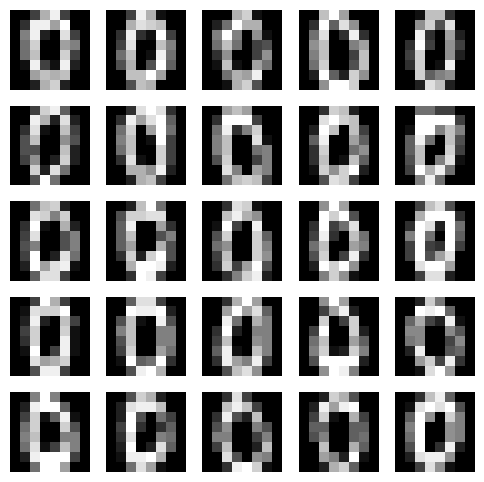

In [56]:
dataset = DigitsDataset(
    csv_file="D:\helpers\optdigits_csv (1).csv",
    label=0,
    transform=transforms.Compose([transforms.ToTensor()]),
)
sampler = RandomSampler(dataset, replacement=True, num_samples=25)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=1, drop_last=True, sampler=sampler
)

ax = plt.figure(figsize=(6, 6))
for index, image in enumerate(iter(dataloader)):
    plt.subplot(5, 5, index +   1)
    plt.imshow(image[0][0][0], cmap="gray")
    plt.axis("off")

In [133]:
def get_archstring(arch):
    return "".join([re.sub(r'[0-9]|\]|\[', '', s) for s in arch.copy()])

architectures = [
        ["var", "enc[2]", "var"],
        ["var", "var", "enc[2]", "var", "var"],
        ["var", "enc[1]", "var", "enc[3]", "var"],
        ["var", "var", "enc[1]", "var", "var", "enc[3]", "var", "var"],
        ["var", "enc[0]", "var", "enc[2]", "var", "enc[4]", "var"],
        ["var", "enc[1]", "var", "enc[3]", "var", "enc[5]", "var", "enc[7]", "var"],
]
archstrings = [get_archstring(s) for s in architectures]

In [134]:
def plot_loss(loss_in, ax):
    
    arr = np.asarray(loss_in)
    ax.clear()

    if arr.size == 0:
        ax.text(0.5, 0.5, "No loss data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title("Loss Evolution"); ax.set_xlabel("Iteration"); ax.set_ylabel("Loss Value")
        return

    if arr.ndim == 2:  # (steps,2)
        D = arr[:, 0] / 2.0
        G = arr[:, 1]
        ax.plot(D, label="D Loss")
        ax.plot(G, label="G Loss")
    elif arr.ndim == 3:  # (runs,steps,2)
        D = arr[:, :, 0] / 2.0
        G = arr[:, :, 1]
        ax.plot(D.T, alpha=0.15, lw=1)
        ax.plot(G.T, alpha=0.15, lw=1)
        ax.plot(D.mean(axis=0), label="D Loss (mean)", lw=2)
        ax.plot(G.mean(axis=0), label="G Loss (mean)", lw=2)
    else:
        ax.text(0.5, 0.5, f"Unexpected loss shape: {arr.shape}", ha="center", va="center", transform=ax.transAxes)

    ax.set_title("Loss Evolution")
    ax.set_xlabel("Iteration"); ax.set_ylabel("Loss Value"); ax.legend()

In [135]:
def _autocontrast_row(v, eps=1e-6, tol=5e-3):
    x = np.asarray(v, dtype=np.float32)
    x = np.nan_to_num(x, nan=0.0, posinf=1.0, neginf=0.0)
    # light squash if clearly outside [0,1]
    if x.min() < 0.0 or x.max() > 1.0:
        x = 1.0 / (1.0 + np.exp(-x))
    x_min, x_max = float(x.min()), float(x.max())
    span = x_max - x_min
    if span >= tol:
        y = (x - x_min) / max(span, eps)
    else:
        xc  = x - x.mean()
        std = float(xc.std())
        y   = (xc / max(std, eps)) * 0.15 + 0.5
    return np.clip(y, 0.0, 1.0)

def _autocontrast_rows(arr):
    if arr.size == 0: return arr
    return np.stack([_autocontrast_row(r) for r in np.asarray(arr)], axis=0)

def _render_from_fake(fake_arr, axes):
    if fake_arr is None or fake_arr.size == 0 or len(axes) == 0:
        for ax in axes: ax.axis("off")
        return
    arr = np.asarray(fake_arr)
    if arr.ndim != 2:
        arr = arr.reshape(-1, arr.shape[-1])
    steps, pixels = arr.shape
    k = len(axes)
    idxs = np.linspace(max(1, steps // 3), steps, num=k, endpoint=True, dtype=int) - 1
    idxs = np.clip(np.unique(idxs), 0, steps - 1)
    if len(idxs) < k:
        idxs = np.pad(idxs, (0, k - len(idxs)), mode="edge")
    for ax, t in zip(axes, idxs):
        img = _autocontrast_row(arr[t])
        img8 = np.clip(img * 255.0, 0, 255).astype(np.uint8).reshape(8, 8)
        ax.imshow(img8, cmap="gray"); ax.axis("off")

In [137]:


def plot_progress(fake_runs, axes):
 
    arr = np.asarray(fake_runs)

    # clear axes
    for ax in axes:
        ax.clear()
        ax.axis("off")

    if arr.size == 0 or len(axes) == 0:
        return

    # unify to (runs, steps, pixels)
    if arr.ndim == 2:          # single run
        arr = arr[None, ...]   # -> (1, steps, pixels)
    elif arr.ndim != 3:
        axes[0].text(0.5, 0.5, f"Unexpected shape: {arr.shape}",
                     ha="center", va="center", transform=axes[0].transAxes)
        return

    runs, steps, pixels = arr.shape

    
    if steps >= 4:
        chunks = [arr[:, i::4, :] for i in range(4)]              # list of (runs, ceil(steps/4), pixels)
        fake_mean = np.mean(np.mean(np.array(chunks), axis=0), axis=0)  # -> (ceil(steps/4), pixels)
    else:
        fake_mean = arr.mean(axis=0)  # (steps, pixels)

    steps2 = fake_mean.shape[0]
    k = len(axes)

    
    idxs = np.linspace(1, steps2, num=k, endpoint=True, dtype=int) - 1
    idxs = np.clip(np.unique(idxs), 0, steps2 - 1)
    if len(idxs) < k:  # pad if uniq collapsed
        idxs = np.pad(idxs, (0, k - len(idxs)), mode="edge")

    for ax, t in zip(axes, idxs):
        img = _autocontrast_row(fake_mean[t])  # (pixels,) in [0,1]
        img8 = np.clip(img * 255.0, 0, 255).astype(np.uint8).reshape(8, 8)
        ax.imshow(img8, cmap="gray")
        ax.set_title(f"Iter {t}", fontsize=10)
        ax.axis("off")

    # row title
    axes[0].text(0.0, 1.10, "Image Evolution",
                 transform=axes[0].transAxes, ha="left", va="bottom", fontsize=12)




In [138]:
def plot_results(params_runs, config, axes, best_run=None):
    
    if not axes:
        return
    for ax in axes:
        ax.clear(); ax.axis("off")

    if not params_runs:
        axes[0].set_title("Generated Images", fontsize=14, pad=10)
        return

    qgan = QGAN(
        image_size=8,
        gen_count=config["gen_count"],
        gen_arch=config["arch"],
        input_state=pcvl.BasicState(config["input_state"]),
        noise_dim=config["noise_dim"],
        batch_size=4,
        pnr=config["pnr"],
        lossy=False,
    )
    qgan.G.eval()

    def _apply_params_to_G(vec):
        if hasattr(qgan.G, "update_var_params"):
            qgan.G.update_var_params(vec)
            return True
        # Try to push into each sublayer.theta if lengths match
        if hasattr(qgan.G, "layers"):
            thetas = [getattr(L, "theta", None) for L in qgan.G.layers]
            flat_thetas = [t.view(-1) for t in thetas if isinstance(t, torch.Tensor)]
            total = sum(t.numel() for t in flat_thetas)
            v = torch.as_tensor(vec, dtype=torch.float32, device=qgan.device)
            if v.numel() == total:
                offset = 0
                for t in thetas:
                    if isinstance(t, torch.Tensor):
                        n = t.numel()
                        t.data.copy_(v[offset:offset+n].view_as(t))
                        offset += n
                return True
        return False

    # --- Generate samples for each run
    device = qgan.device
    num_axes = len(axes)
    final_results = []  # list of (num_axes, 64)
    for params in params_runs:
        p = np.asarray(params)
        p = p[-1] if p.ndim == 2 else p  # last snapshot if (T,P)

        _apply_params_to_G(p)

        # New noise per axis for diversity
        z = torch.randn(num_axes, qgan.latent_dim, device=device)
        with torch.no_grad():
            # G returns (-1,1); map to [0,1] for display
            out = qgan.G(z)                                # (N, 64) in (-1,1)
            out01 = ((out + 1.0) * 0.5).clamp(0.0, 1.0)    # [0,1]
            final_results.append(out01.cpu().numpy())

    final_arr = np.stack(final_results, axis=0)  # (runs, num_axes, 64)

    # --- Choose what to show per axis
    rng = np.random.default_rng()
    for i, ax in enumerate(axes):
        if best_run is not None and 0 <= best_run < final_arr.shape[0]:
            run_idx = best_run
        else:
            # pick a different run per axis (no averaging → more variety)
            run_idx = rng.integers(0, final_arr.shape[0])
        image_flat = final_arr[run_idx, i, :]  # (64,)
        img = (np.clip(image_flat, 0.0, 1.0) * 255.0).astype(np.uint8).reshape(8, 8)
        ax.imshow(img, cmap="gray", vmin=0, vmax=255)
        ax.axis("off")

    axes[0].set_title("Generated Images", fontsize=14, pad=10)


In [120]:
from numpy.random import default_rng

varencvar


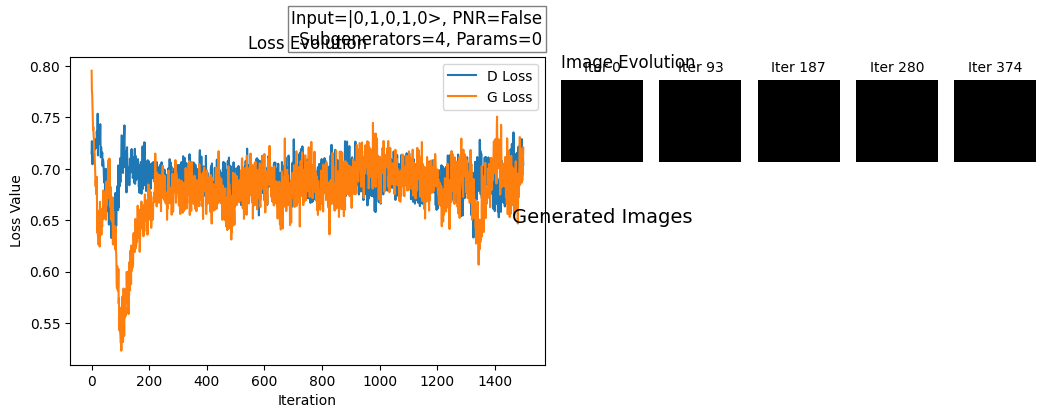

varvarencvarvar


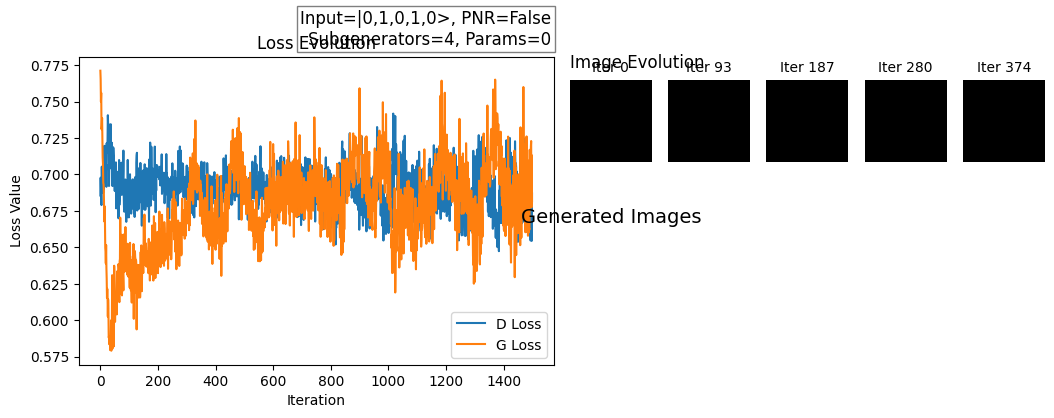

varencvarencvar


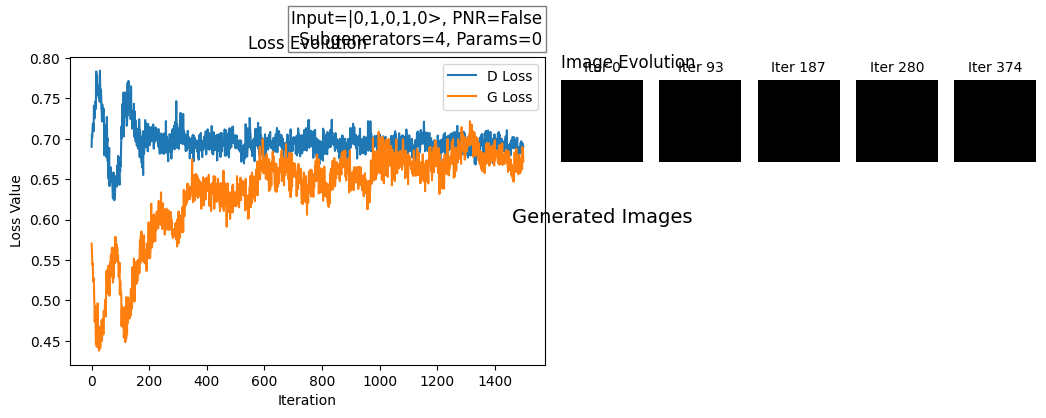

varvarencvarvarencvarvar
varencvarencvarencvar
varencvarencvarencvarencvar


In [139]:
#RUN = 1  # fixed

for archstring in archstrings:
    print(archstring)
    for config_num in range(3):
        config_path = os.path.join(path, f"config_{config_num}")
        with open(os.path.join(config_path, "config.json")) as c:
            config = json.load(c)

        if get_archstring(config["arch"]) != archstring:
            continue

        full_path   = os.path.join(path, f"config_{config_num}", f"run_{RUN}")
        loss_file   = os.path.join(full_path, "loss_progress.csv")
        fake_file   = os.path.join(full_path, "fake_progress.csv")
        params_file = os.path.join(full_path, "G_params_progress.csv")

        loss_data   = np.loadtxt(loss_file, delimiter=",", skiprows=1) if os.path.exists(loss_file) else np.empty((0,))
        fake_data   = np.loadtxt(fake_file, delimiter=",")            if os.path.exists(fake_file) else np.empty((0,))
        params_data = np.loadtxt(params_file, delimiter=",")          if os.path.exists(params_file) else None

        fig = plt.figure(figsize=(15, 4))
        gs = fig.add_gridspec(2, 12)
        loss_ax   = fig.add_subplot(gs[:, :5])
        prog_axes = [fig.add_subplot(gs[0, 5+i]) for i in range(5)]
        res_axes  = [fig.add_subplot(gs[1, 5+i]) for i in range(5)]

        # loss: pass 2D if single run; otherwise stack if you ever add more runs
        plot_loss(loss_data, loss_ax)

        # progress: expects 2D (steps,pixels) or 3D; we have 2D for run=1
        plot_progress(fake_data, prog_axes)

        # generated images
        params_list = [params_data] if params_data is not None else []
        plot_results(params_list, config, res_axes, best_run=0 if params_list else None)

        n_params = (params_data.shape[-1]) if params_data is not None else 0
        configinfo = (
            f"Input={pcvl.BasicState(config['input_state'])}, PNR={config['pnr']}\n"
            f"Subgenerators={config['gen_count']}, Params={n_params}"
        )
        loss_ax.text(
            x=0.995, y=1.04, s=configinfo, ha="right",
            bbox=dict(boxstyle='square, pad=0.2', facecolor='white', alpha=0.5),
            transform=loss_ax.transAxes, fontsize=12
        )

        plt.subplots_adjust(hspace=0.4)

    plt.show()



varencvar


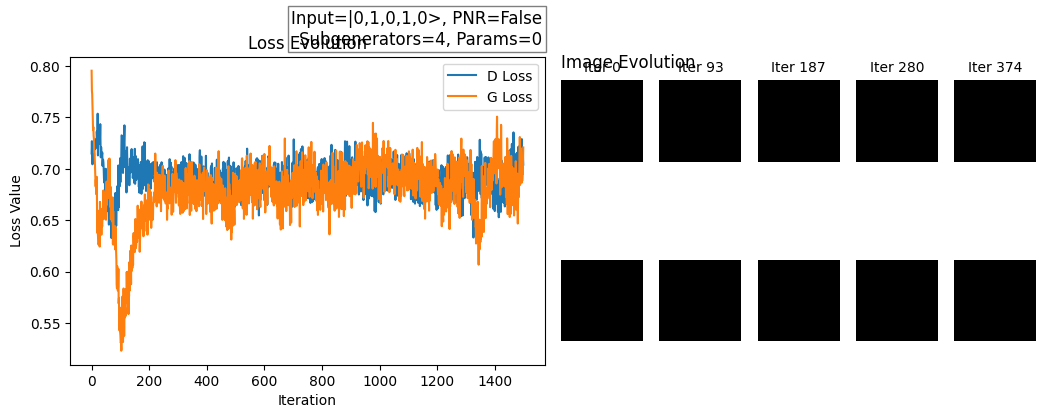

varvarencvarvar


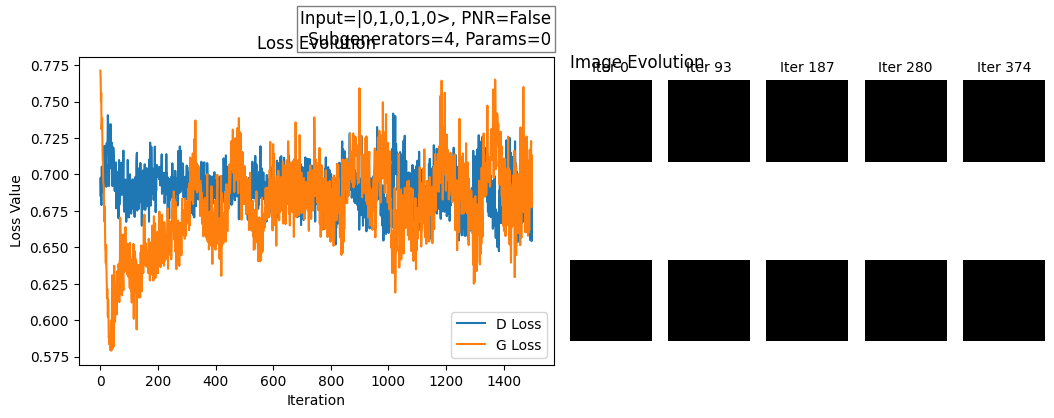

varencvarencvar


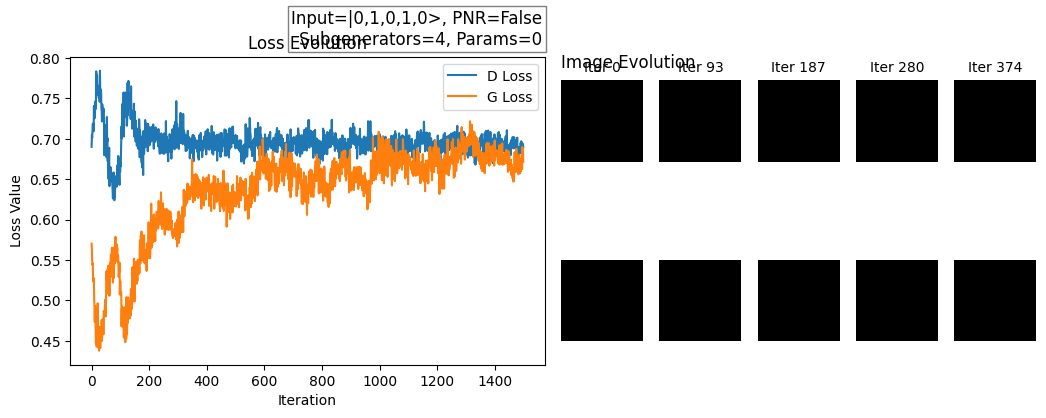

varvarencvarvarencvarvar
varencvarencvarencvar
varencvarencvarencvarencvar


In [140]:
RUN = 1  # fixed

for archstring in archstrings:
    print(archstring)
    for config_num in range(3):
        config_path = os.path.join(path, f"config_{config_num}")
        with open(os.path.join(config_path, "config.json")) as c:
            config = json.load(c)

        if get_archstring(config["arch"]) != archstring:
            continue

        full_path   = os.path.join(path, f"config_{config_num}", f"run_{RUN}")
        loss_file   = os.path.join(full_path, "loss_progress.csv")
        fake_file   = os.path.join(full_path, "fake_progress.csv")
        params_file = os.path.join(full_path, "G_params_progress.csv")

        # --- load (single run) ---
        loss_data   = np.loadtxt(loss_file, delimiter=",", skiprows=1) if os.path.exists(loss_file) else np.empty((0, 2))
        fake_data   = np.loadtxt(fake_file, delimiter=",")            if os.path.exists(fake_file) else np.empty((0, 64))
        params_data = np.loadtxt(params_file, delimiter=",")          if os.path.exists(params_file) else None

        # --- normalize shapes defensively ---
        if loss_data.ndim == 1 and loss_data.size >= 2:
            loss_data = loss_data[None, :]  # (1,2)

        if fake_data.ndim == 1:
            fake_data = fake_data[None, :]
        # force to 64 pixels (8x8) when possible
        if fake_data.size and fake_data.shape[1] != 64 and (fake_data.size % 64 == 0):
            steps = fake_data.shape[0]
            fake_data = fake_data.reshape(steps, -1)[:, :64]

        if params_data is not None and params_data.ndim == 1:
            params_data = params_data[None, :]  # (1,P)

        # --- figure & axes ---
        fig = plt.figure(figsize=(15, 4))
        gs = fig.add_gridspec(2, 12)
        loss_ax   = fig.add_subplot(gs[:, :5])
        prog_axes = [fig.add_subplot(gs[0, 5+i]) for i in range(5)]
        res_axes  = [fig.add_subplot(gs[1, 5+i]) for i in range(5)]

        # loss: pass 2D for single run
        plot_loss(loss_data, loss_ax)

        # progress: auto-contrast frames before plotting so they aren't black
        ac_fake = _autocontrast_rows(fake_data) if fake_data.size else fake_data
        plot_progress(ac_fake, prog_axes)

        # generated images:
        params_list = [params_data] if params_data is not None else []
        if params_list and params_list[0] is not None and params_list[0].size:
            # try your original plot_results first (if it regenerates from params)
            try:
                plot_results(params_list, config, res_axes, best_run=0)
            except Exception:
                # fallback to saved fakes if regeneration fails
                _render_from_fake(ac_fake, res_axes)
        else:
            # no params saved (Params=0) -> show saved fakes (auto-contrasted)
            _render_from_fake(ac_fake, res_axes)

        n_params = (params_data.shape[-1]) if params_data is not None else 0
        configinfo = (
            f"Input={pcvl.BasicState(config['input_state'])}, PNR={config['pnr']}\n"
            f"Subgenerators={config['gen_count']}, Params={n_params}"
        )
        loss_ax.text(
            x=0.995, y=1.04, s=configinfo, ha="right",
            bbox=dict(boxstyle='square, pad=0.2', facecolor='white', alpha=0.5),
            transform=loss_ax.transAxes, fontsize=12
        )

        plt.subplots_adjust(hspace=0.4)

    plt.show()

In [109]:
def plot_loss(loss_data, ax):
    D_loss = loss_data[:, 0] / 2
    G_loss = loss_data[:, 1]
    ax.plot(D_loss, label="D Loss")
    ax.plot(G_loss, label="G Loss")
    ax.set_title("Loss Evolution")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss Value")
    ax.legend()